In [1]:
%load_ext autoreload
    
%autoreload 2

In [2]:
import time
from wrapt_timeout_decorator import timeout

In [3]:
from io import StringIO
import os, sys

In [4]:
import bz2
import pickle

In [5]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import chi2
from math import floor
from sklearn.svm import LinearSVC
import operator
from functools import reduce
from Utilities.G2Dependency import *
from Utilities.ClassicMM import *
from ipynb.fs.defs.GraphReader import GraphReader

from ipynb.fs.defs.RandomWalk import RandomWalk
import sys
import os
from random import shuffle
from multiprocessing import Semaphore
import time

import datetime
from contextlib import redirect_stdout

In [6]:
import multiprocessing.pool
from contextlib import closing
from functools import partial

class NoDaemonProcess(multiprocessing.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class Pool(multiprocessing.pool.Pool):
    Process = NoDaemonProcess

In [7]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [8]:
class MMPC():
    
    def init(self,s):
        global semaphore
        semaphore = s
        return
    
   
    
    
    def __init__(self, alpha, delta=0.0, max_neighbours=1):
        
        self._RW = RandomWalk(alpha, delta, max_neighbours)
        self._alpha = alpha
        self._arrX= None
        self._dep_counter = {}
        return
    
    def __reset_dep_counter(self):
        self._dep_counter = {}
        return
    
    def __increase_dep_counter(self, degree,effective):
        if degree not in self._dep_counter.keys():
            self._dep_counter[degree] = {}
            self._dep_counter[degree][True] = 0
            self._dep_counter[degree][False] = 0
        self._dep_counter[degree][effective] += 1
        return
        
    def fit(self, X):
        """
        Fit training dataset X
        """
        x_heads = []
        for i in range(0,len(X.keys())):
            max_v=1
            for row in X[X.keys()[i]]:
#                 print(type(row))
#                 if isinstance(row, str):
#                     print("f_u")
#                     row = int(row)
                if (row>max_v-1):
                    max_v+=row-(max_v-1)
            x_heads.append("Node"+str(i+1)+"@"+str(max_v))
        X.columns = x_heads
        
        self._arrX = arrayX(X)
        self._RW.fit(X)
        self._G2Dep = self._RW.get_G2Dep()
        self._rw_iter = int(100*np.log(len(self._arrX))/2)
        print("Finished fitting of X in MMPC object")
        return
    
    
    def __classic_filtering_phase(self, TargetNode, CPC, X, alpha):
        filtered_cpc = []
        if (len(CPC)>1):
            for i in range(len(CPC)-1,-1,-1):
                evaluated_node = CPC.pop(i)
                if self.__exist_dseparator(TargetNode,evaluated_node,CPC,X,alpha)[0] == False:
                    filtered_cpc.append(evaluated_node)
        else:
            return CPC
        return filtered_cpc
    
    
    def __rw_node_v2(self, t_index, t_iter, CPC):
        # will work at name level, then reconstruct list
        cpc_names = [x['name'].split('@')[0] for x in CPC]
        evaluation = self._RW.evaluate_node_index(t_index,t_iter)
        results = [x for x in sorted(evaluation["Node"+str(t_index+1)].items(), key=lambda x:x[1], reverse=True)]
        cpc_results = []
        g_ratio = (1+5**(1/2))/2
        set_results = [x[0] for x in results if x[0] in cpc_names and (x[1])>t_iter*g_ratio/(len(self._arrX))]
        
        set_returnable = []
        for i in range(len(CPC)-1,-1,-1):
            if CPC[i]['name'].split('@')[0] in set_results:
                set_returnable.append(CPC.pop(i))
        #print([x['name'] for x in CPC])
        return [set_returnable, CPC]
    
    def __rw_community_selection_phase_v2(self, TargetNode, CPC, X, alpha, n_iter):
        votation_arr = []
        if (len(CPC)>1):
            # will divide the sets in np.log(size)*2
            CPC = sorted(CPC,key=lambda x:self.__get_g2dep(TargetNode,x,[],alpha)[0],reverse = True)
            # 0 degree
            for n in CPC:
                print("my boys?")
                self.__increase_dep_counter("degree_0",True)
            CPC_copy = list(CPC)
            nodes_sets = []
            if (len(CPC)>5):
                while(len(CPC_copy)>0):
                    if len(CPC_copy) == 1:
                        nodes_sets.append([CPC_copy.pop(0)])
                        break
                        
                    rand_index = random.randint(0,len(CPC_copy))-1                    
                    rand_true_index = int(CPC_copy[rand_index]['name'].split('@')[0].split('Node')[1]) - 1
                    rand_node = CPC_copy.pop(rand_index)
                    for rw_times in range(0,n_iter*len(CPC)):
                        print("is this it?")
                        self.__increase_dep_counter("degree_0",True)
                    rw_results = self.__rw_node_v2(rand_true_index, n_iter, CPC_copy)
                    node_set = [rand_node] + rw_results[0]
                    CPC_copy = rw_results[1]
                    nodes_sets.append(node_set)
            else:
                nodes_sets.append(CPC)
            pre_cpc = []
            for n_set in nodes_sets:
                print([x['name'] for x in n_set])
                if (len(n_set)>1):
                    print("n_set of length: "+str(len(n_set)))
                    result_set = self.__classic_filtering_phase(TargetNode, n_set, X, alpha)
                    pre_cpc.append(result_set)
                else:
                    print("n_set of length: 1")
                    pre_cpc.append(n_set) 
                    continue
                    
            return pre_cpc
        else:
            return [CPC]
    
    
    def evaluate_mod_1(self, index):
        start = time.clock()
        CPC=[]
        alpha = self._alpha
        X = self._arrX
        TargetNode = [x for x in self._arrX if x['name'].split('@')[0] == ("Node"+str(index+1))][0]
        Universe = arrayUniverse(TargetNode['name'], self._arrX)
        
        
        CPC=[]
        print("Entering Phase I")
        print("MMPC_beggining: \n"+str(len(Universe)))
        while len(Universe)>0:
            t_start = time.time()
            CPC_old = list(CPC) # copy
            maxminheur=self.__mm_heuristic(TargetNode,CPC,list(Universe),X,alpha)
            F = maxminheur[0]
            assocF = maxminheur[1]
            Universe = maxminheur[2]
            if assocF > 0:
                CPC.append(F)
                indF=Universe.index(F)
                Universe.pop(indF)
            #if (len(CPC)==len(CPC_old)) or (len(CPC)>0.3*(len(Universe)-1)):
            if (len(CPC)==len(CPC_old)):
                break
            print("\nUniverse actual size:")
            print(len(Universe))
            print("CPC actual size:")
            print(len(CPC))
            print("CPC contents:")
            print([x['name'] for x in CPC])
            print("Time elapsed was:",time.time()-t_start)
            # Phase 2: Backward
            
            if len(CPC)>1:
                CPC=CPC[::-1]
                print("\nEntering Phase II")
                Z=list(CPC)
                for i in range(len(CPC)-1,-1,-1):
                    # index is i
                    Z.pop(i)
                    #print("Analyzing D-separator for ",CPC[i]['name'])
                    if self.__exist_dseparator(TargetNode,CPC[i],Z,X,alpha)[0] == True:
                        #print("it did exist! removing from cpc.")
                        CPC.pop(i)
                CPC=CPC[::-1]

        
        stop = time.clock()
        results = {}
        results['CPC'] = [x['name'] for x in CPC]
        results['time'] = stop-start
        results['target'] = 'Node@'+str(index+1)
        results["counter"] = self._dep_counter
        
        return results
        
        
    def evaluate_mod_2(self,index):
        start = time.clock()
        CPC=[]
        alpha = self._alpha
        X = self._arrX
        TargetNode = [x for x in self._arrX if x['name'].split('@')[0] == ("Node"+str(index+1))][0]
        Universe = arrayUniverse(TargetNode['name'], self._arrX)
        
        
        CPC=[]
        print("Entering Phase I")
        print("MMPC_beggining: \n"+str(len(Universe)))
        
        while len(Universe)>0:
            t_start = time.time()
            CPC_old = list(CPC) # copy
            maxminheur=self.__mm_heuristic(TargetNode,CPC,list(Universe),X,alpha)
            F = maxminheur[0]
            assocF = maxminheur[1]
            Universe = maxminheur[2]
            if assocF > 0:
                CPC.append(F)
                indF=Universe.index(F)
                Universe.pop(indF)
            #if (len(CPC)==len(CPC_old)) or (len(CPC)>0.3*(len(Universe)-1)):
            if (len(CPC)==len(CPC_old)):
                break
            print("\nUniverse actual size:")
            print(len(Universe))
            print("CPC actual size:")
            print(len(CPC))
            print("CPC contents:")
            print([x['name'] for x in CPC])
            print("Time elapsed was:",time.time()-t_start)
        
        
        print("\nEntering Community Creation Phase")
        print("CPC size before filtering: "+str(len(CPC)))
            # Embedded RW in backward_phase
        CPC = self.__rw_community_selection_phase_v2(TargetNode,
                                                     CPC,X,alpha,self._rw_iter)
        print("CPC size after filtering: "+str(len(CPC)))
        for n_set in CPC: 
            print(list(map(lambda x:x['name'],n_set)))
            
        stop = time.clock()
        results = {}
        try:
            results['CPC'] = [x['name'] for x in list(itertools.chain.from_iterable(CPC))]
        except:
            results['CPC'] = [x['name'] for x in CPC]
        results['time'] = stop-start
        results['target'] = 'Node@'+str(index+1)
        results["counter"] = self._dep_counter
        return results
        
    def __mm_heuristic_m3(self, TargetNode, CPC, Universe, X, alpha):
        F_arr=[]
        Z = CPC
        fixedCondVars = []
        if (len(CPC)>0):
            Z = CPC[0:-1]           # all but the last one   
            fixedCondVars = [CPC[-1]] # we use last one
            
        if len(Z)>4:
            # will recieve arr of indexes and assoc score
            # if len(Universe)<=4:
                # quite a new process, not yet defined
            n_processes = 4
            s = Semaphore(1)
            with Pool(n_processes,initializer=self.init,initargs=(s,)) as p:
                params_arr = [[TargetNode,Universe[index],Z,fixedCondVars,X,alpha,False] for index in list(range(0,len(Universe)))]
                batch_arr = []
                step = int(len(Universe)/n_processes)
                if step == 0:
                    step = 1
                for n in range(0,n_processes):
                    if (n*step>=len(Universe)):
                        continue
                    batch_arr.append(params_arr[n*step:(n+1)*step])
                if (len(batch_arr) < len(params_arr)):
                    batch_arr.append(params_arr[(n+1)*step:])
                
                results = p.map(partial(self.min_assoc_p),batch_arr)
                
                p.close()
                p.join()
            results = list(itertools.chain.from_iterable(results))
            for i in range(len(Universe)-1,-1,-1):
                # section for parallel dep counter increasing
                for dep_counter_index in results[i][1]:
                    self.__increase_dep_counter(*dep_counter_index)
                if results[i][0]>assocF:
                    assocF = results[i][0]
                    F = Universe[i]
                if (results[i][0]==0):
                    Universe.pop(i)
            return [F_arr, Universe]
            
            
            
        for i in range(len(Universe)-1,-1,-1):
            if (len(Universe[i])==0):
                continue
            assoc, dep_counter_arr = self.__min_assoc(TargetNode,Universe[i],Z,fixedCondVars,X,alpha)
            #assoc = self.__min_assoc_v2(TargetNode,Universe[i],Z,fixedCondVars,X,alpha,10000)
            for dep_counter_index in dep_counter_arr:
                    self.__increase_dep_counter(*dep_counter_index)
            if (assoc>0):
                F_arr.append([Universe[i],assoc])
            if (assoc==0):
                Universe.pop(i)

        return [F_arr,Universe]
        
    def evaluate_mod_3(self,index):
        start = time.clock()
        CPC=[]
        alpha = self._alpha
        X = self._arrX
        TargetNode = [x for x in self._arrX if x['name'].split('@')[0] == ("Node"+str(index+1))][0]
        Universe = arrayUniverse(TargetNode['name'], self._arrX)
        
        print(TargetNode['name'],Universe[0]['name'])
        CPC=[]
        print("Entering Phase I")
        print("MMPC_beggining: \n"+str(len(Universe)))
        
        while len(Universe)>0:
            CPC_old = list(CPC) # copy
            maxminheur=self.__mm_heuristic_m3(TargetNode,CPC,list(Universe),X,alpha)
            F_arr = maxminheur[0]
            if (len(F_arr)>0):
                max_assoc = max([x[1] for x in F_arr])
            else:
                max_assoc = 0
            Universe = maxminheur[1]
            if max_assoc > 0:
                # append all nodes that fulfill the requirements
                newly_added_nodes = []
                for nn in [x[0] for x in F_arr if x[1]>=max_assoc]:
                    newly_added_nodes.append(nn)
                    indF=Universe.index(nn)
                    Universe.pop(indF)
                if (len(newly_added_nodes)>0):
                    CPC+=newly_added_nodes
            
            if (len(CPC)==len(CPC_old)):
                break

        # Phase 2: Backward
        print("\nEntering Phase II")
        CPC = CPC[::-1]
        if len(CPC)>1:
            Z=list(CPC)
            for i in range(len(CPC)-1,-1,-1):
                # index is i
                Z.pop(i)
                #print("Analyzing D-separator for ",CPC[i]['name'])
                if self.__exist_dseparator(TargetNode,CPC[i],Z,X,alpha)[0] == True:
                    #print("it did exist! removing from cpc.")
                    CPC.pop(i)
        stop = time.clock()
        results = {}
        results['CPC'] = [x['name'] for x in CPC]
        results['time'] = stop-start
        results['target'] = 'Node@'+str(index+1)
        results["counter"] = self._dep_counter
        return results
        
    
    def evaluate_mod_1_2(self, index):
        start = time.clock()
        CPC=[]
        alpha = self._alpha
        X = self._arrX
        TargetNode = [x for x in self._arrX if x['name'].split('@')[0] == ("Node"+str(index+1))][0]
        Universe = arrayUniverse(TargetNode['name'], self._arrX)
        
        
        CPC=[]
        print("Entering Phase I")
        print("MMPC_beggining: \n"+str(len(Universe)))
        
        while len(Universe)>0:
            t_start = time.time()
            CPC_old = list(CPC) # copy
            maxminheur=self.__mm_heuristic(TargetNode,CPC,list(Universe),X,alpha)
            F = maxminheur[0]
            assocF = maxminheur[1]
            Universe = maxminheur[2]
            if assocF > 0:
                CPC.append(F)
                indF=Universe.index(F)
                Universe.pop(indF)
            #if (len(CPC)==len(CPC_old)) or (len(CPC)>0.3*(len(Universe)-1)):
            if (len(CPC)==len(CPC_old)):
                break
            print("\nUniverse actual size:")
            print(len(Universe))
            print("CPC actual size:")
            print(len(CPC))
            print("CPC contents:")
            print([x['name'] for x in CPC])
            print("Time elapsed was:",time.time()-t_start)
        
        
            print("\nEntering Community Creation Phase")
            print("CPC size before filtering: "+str(len(CPC)))
                # Embedded RW in backward_phase
            CPC = self.__rw_community_selection_phase_v2(TargetNode,
                                                         CPC,X,alpha,self._rw_iter)
            print("CPC size after filtering: "+str(len(CPC)))
            for n_set in CPC: 
                print(list(map(lambda x:x['name'],n_set)))
            if (len(Universe)>0):
                CPC = list(itertools.chain.from_iterable(CPC))
            
        stop = time.clock()
        results = {}
        try:
            results['CPC'] = [x['name'] for x in list(itertools.chain.from_iterable(CPC))]
        except:
            results['CPC'] = [x['name'] for x in CPC]
        results['time'] = stop-start
        results['target'] = 'Node@'+str(index+1)
        results["counter"] = self._dep_counter
        return results
    
    
    def evaluate_mod_1_3(self, index):
        start = time.clock()
        CPC=[]
        alpha = self._alpha
        X = self._arrX
        TargetNode = [x for x in self._arrX if x['name'].split('@')[0] == ("Node"+str(index+1))][0]
        Universe = arrayUniverse(TargetNode['name'], self._arrX)
        
        
        CPC=[]
        print("Entering Phase I")
        print("MMPC_beggining: \n"+str(len(Universe)))
        while len(Universe)>0:
            t_start = time.time()
            CPC_old = list(CPC) # copy
            maxminheur=self.__mm_heuristic_m3(TargetNode,CPC,list(Universe),X,alpha)
            F_arr = maxminheur[0]
            if (len(F_arr)>0):
                max_assoc = max([x[1] for x in F_arr])
            else:
                max_assoc = 0
            Universe = maxminheur[1]
            if max_assoc > 0:
                # append all nodes that fulfill the requirements
                newly_added_nodes = []
                for nn in [x[0] for x in F_arr if x[1]>=max_assoc]:
                    newly_added_nodes.append(nn)
                    indF=Universe.index(nn)
                    Universe.pop(indF)
                if (len(newly_added_nodes)>0):
                    CPC+=newly_added_nodes
            #if (len(CPC)==len(CPC_old)) or (len(CPC)>0.3*(len(Universe)-1)):
            if (len(CPC)==len(CPC_old)):
                break
            print("\nUniverse actual size:")
            print(len(Universe))
            print("CPC actual size:")
            print(len(CPC))
            print("CPC contents:")
            print([x['name'] for x in CPC])
            print("Time elapsed was:",time.time()-t_start)
            # Phase 2: Backward
            
            if len(CPC)>1:
                CPC=CPC[::-1]
                print("\nEntering Phase II")
                Z=list(CPC)
                for i in range(len(CPC)-1,-1,-1):
                    # index is i
                    Z.pop(i)
                    #print("Analyzing D-separator for ",CPC[i]['name'])
                    if self.__exist_dseparator(TargetNode,CPC[i],Z,X,alpha)[0] == True:
                        #print("it did exist! removing from cpc.")
                        CPC.pop(i)
                CPC=CPC[::-1]

        
        stop = time.clock()
        results = {}
        results['CPC'] = [x['name'] for x in CPC]
        results['time'] = stop-start
        results['target'] = 'Node@'+str(index+1)
        results["counter"] = self._dep_counter
        
        return results
    
    
    def evaluate_mod_2_3(self,index):
        start = time.clock()
        CPC=[]
        alpha = self._alpha
        X = self._arrX
        TargetNode = [x for x in self._arrX if x['name'].split('@')[0] == ("Node"+str(index+1))][0]
        Universe = arrayUniverse(TargetNode['name'], self._arrX)
        
        print(TargetNode['name'],Universe[0]['name'])
        CPC=[]
        print("Entering Phase I")
        print("MMPC_beggining: \n"+str(len(Universe)))
        
        while len(Universe)>0:
            CPC_old = list(CPC) # copy
            maxminheur=self.__mm_heuristic_m3(TargetNode,CPC,list(Universe),X,alpha)
            F_arr = maxminheur[0]
            if (len(F_arr)>0):
                max_assoc = max([x[1] for x in F_arr])
            else:
                max_assoc = 0
            Universe = maxminheur[1]
            if max_assoc > 0:
                # append all nodes that fulfill the requirements
                newly_added_nodes = []
                for nn in [x[0] for x in F_arr if x[1]>=max_assoc]:
                    newly_added_nodes.append(nn)
                    indF=Universe.index(nn)
                    Universe.pop(indF)
                if (len(newly_added_nodes)>0):
                    CPC+=newly_added_nodes
            
            if (len(CPC)==len(CPC_old)):
                break

        print("\nEntering Community Creation Phase")
        print("CPC size before filtering: "+str(len(CPC)))
            # Embedded RW in backward_phase
        CPC = self.__rw_community_selection_phase_v2(TargetNode,
                                                     CPC,X,alpha,self._rw_iter)
        print("CPC size after filtering: "+str(len(CPC)))
        for n_set in CPC: 
            print(list(map(lambda x:x['name'],n_set)))
            
        stop = time.clock()
        results = {}
        try:
            results['CPC'] = [x['name'] for x in list(itertools.chain.from_iterable(CPC))]
        except:
            results['CPC'] = [x['name'] for x in CPC]
        results['time'] = stop-start
        results['target'] = 'Node@'+str(index+1)
        results["counter"] = self._dep_counter
        
        return results
    
    def __pc_len(self, CPC):
        counter = 0
        for n_set in CPC:
            counter += len(n_set)
        return counter
    
    def __min_assoc_v3(self, TargetNode, Xi, super_Z, X, alpha):
    
        min_assoc=999
        if self.__pc_len(super_Z)==0:
            # min_assoc = self._G2Dep.dependency(TargetNode, Xi, [], alpha) 
            dep, dep_counter, dep_effective = self.__get_g2dep(TargetNode,Xi,[], alpha)
            self.__increase_dep_counter(dep_counter,dep_effective)
            min_assoc = dep
        elif self.__pc_len(super_Z)==1:
            # min_assoc = self._G2Dep.dependency(TargetNode, Xi, super_Z[0], alpha)
            dep, dep_counter, dep_effective = self.__get_g2dep(TargetNode, Xi, super_Z[0], alpha)
            self.__increase_dep_counter(dep_counter,dep_effective)
            min_assoc = dep
        else:
            for Z in super_Z:
                for IDsubsetZ_dec in range(0,2**len(Z)-1):
                    IDsubsetZ_bin = bin(IDsubsetZ_dec)
                    subsetZ = getZsubset(IDsubsetZ_bin,Z)            
                    # subsetZ_assoc=self._G2Dep.dependency(TargetNode, Xi, subsetZ,alpha)
                    dep, dep_counter,dep_effective = self.__get_g2dep(TargetNode, Xi, subsetZ,alpha)
                    self.__increase_dep_counter(dep_counter,dep_effective)
                    subsetZ_assoc = dep
                    #counter+=1
                    #print(subsetZ_assoc[IDsubsetZ_dec])
                    if subsetZ_assoc < min_assoc:
                        min_assoc = subsetZ_assoc
                        if (min_assoc==0):
                            break
        return min_assoc
    
    def __mm_heuristic_v3(self, TargetNode, CPC, Universe, X, alpha):
        F_arr=[]
        Z = CPC
        if (len(CPC)>0):
            Z = CPC   
        for i in range(len(Universe)-1,-1,-1):
            if (len(Universe[i])==0):
                continue
            assoc = self.__min_assoc_v3(TargetNode,Universe[i],Z,X,alpha)
            #assoc = self.__min_assoc_v2(TargetNode,Universe[i],Z,fixedCondVars,X,alpha,10000)
            if (assoc>0):
                F_arr.append([Universe[i],assoc])
            if (assoc==0):
                Universe.pop(i)

        return [F_arr,Universe]
    
    def evaluate_mod_1_2_3(self,index):
        start = time.clock()
        CPC=[]
        alpha = self._alpha
        X = self._arrX
        TargetNode = [x for x in self._arrX if x['name'].split('@')[0] == ("Node"+str(index+1))][0]
        Universe = arrayUniverse(TargetNode['name'], self._arrX)
        print("Entering Phase I")
        print("MMPC_beggining: \n"+str(len(Universe)))
        while len(Universe)>0:
            CPC_old = list(CPC) # copy
            maxminheur=self.__mm_heuristic_v3(TargetNode,CPC,list(Universe),X,alpha)
            F_arr = maxminheur[0]
            if (len(F_arr)>0):
                max_assoc = max([x[1] for x in F_arr])
            else:
                max_assoc = 0
            Universe = maxminheur[1]
            if max_assoc > 0:
                # append all nodes that fulfill the requirements
                newly_added_nodes = []
                for nn in [x[0] for x in F_arr if x[1]>=max_assoc]:
                    newly_added_nodes.append(nn)
                    indF=Universe.index(nn)
                    Universe.pop(indF)
                if (len(newly_added_nodes)>0):
                    CPC.append(newly_added_nodes)
            
            if (self.__pc_len(CPC)==self.__pc_len(CPC_old)):
                break
            print("\nUniverse actual size:")
            print(len(Universe))
            print("CPC size before filtering: "+str(self.__pc_len(CPC)))
            # Embedded RW in backward_phase
            CPC = self.__rw_community_selection_phase_v2(TargetNode,
                                                         list(itertools.chain.from_iterable(CPC))
                                                         ,X,alpha,self._rw_iter)
            print("CPC size after filtering: "+str(self.__pc_len(CPC)))
            for n_set in CPC: 
                print(list(map(lambda x:x['name'],n_set)))
        
        stop = time.clock()
        results = {}
        try:
            results['CPC'] = [x['name'] for x in list(itertools.chain.from_iterable(CPC))]
        except:
            results['CPC'] = [x['name'] for x in CPC]
        results['time'] = stop-start
        results['target'] = 'Node@'+str(index+1)
        results["counter"] = self._dep_counter
        return results
        
    def evaluate(self, index, method='MMPC'):
        
        self.__reset_dep_counter()
        
        if method=='MODS_1':
            return self.evaluate_mod_1(index)
        if method=='MODS_2':
            return self.evaluate_mod_2(index)
        if method=='MODS_3':
            return self.evaluate_mod_3(index)
        if method=='MODS_1_2':
            return self.evaluate_mod_1_2(index)
        if method=='MODS_1_3':
            return self.evaluate_mod_1_3(index)
        if method=='MODS_1_2_3':
            return self.evaluate_mod_1_2_3(index)
        
        start = time.clock()
        CPC=[]
        alpha = self._alpha
        X = self._arrX
        TargetNode = [x for x in self._arrX if x['name'].split('@')[0] == ("Node"+str(index+1))][0]
        Universe = arrayUniverse(TargetNode['name'], self._arrX)
        
        
        CPC=[]
        print("Entering Phase I")
        print("MMPC_beggining: \n"+str(len(Universe)))
        while len(Universe)>0:
            t_start = time.time()
            CPC_old = list(CPC) # copy
            maxminheur=self.__mm_heuristic(TargetNode,CPC,list(Universe),X,alpha)
            F = maxminheur[0]
            assocF = maxminheur[1]
            Universe = maxminheur[2]
            if assocF > 0:
                CPC.append(F)
                indF=Universe.index(F)
                Universe.pop(indF)
            #if (len(CPC)==len(CPC_old)) or (len(CPC)>0.3*(len(Universe)-1)):
            if (len(CPC)==len(CPC_old)):
                break
            print("\nUniverse actual size:")
            print(len(Universe))
            print("CPC actual size:")
            print(len(CPC))
            print("CPC contents:")
            print([x['name'] for x in CPC])
            print("Time elapsed was:",time.time()-t_start)

        # Phase 2: Backward
        print("\nEntering Phase II")
        CPC=CPC[::-1]
        if len(CPC)>1:
            Z=list(CPC)
            for i in range(len(CPC)-1,-1,-1):
                # index is i
                Z.pop(i)
                #print("Analyzing D-separator for ",CPC[i]['name'])
                if self.__exist_dseparator(TargetNode,CPC[i],Z,X,alpha)[0] == True:
                    #print("it did exist! removing from cpc.")
                    CPC.pop(i)
        stop = time.clock()
        results = {}
        results['CPC'] = [x['name'] for x in CPC]
        results['time'] = stop-start
        results['target'] = 'Node@'+str(index+1)
        results["counter"] = self._dep_counter
        
        return results
        
    def __exist_dseparator(self, TargetNode,Xi, Z, X, alpha):
        flagExist = False
        dsepSet=[]
        #counter=0
        #print_names(Z)
        for i in range((2**len(Z))-1,0,-1): # modded 20190226 00:00
            IDsubsetZ_dec = i
            IDsubsetZ_bin = bin(IDsubsetZ_dec)
            subsetZ = getZsubset(IDsubsetZ_bin,Z)
            # no cache
            #print("from exist dseparator")
            dep, dep_counter, dep_effective = self.__get_g2dep(TargetNode,Xi,subsetZ, alpha)
            self.__increase_dep_counter(dep_counter,dep_effective)
            #print(subsetZ)
            #print(dep)
            if (dep==0):
                flagExist = True
                dsepSet = subsetZ
                break
        #print("Module exist d-separator: ",counter)
        return [flagExist,dsepSet]

In [9]:
class MMPC(MMPC):
    def __mm_heuristic(self, TargetNode, CPC, Universe, X, alpha):
        F=[]
        assocF=-1
        Z = CPC
        fixedCondVars = []
        if (len(CPC)>0):
            Z = CPC[0:-1]           # all but the last one   
            fixedCondVars = [CPC[-1]] # we use last one
            
            
        if len(Z)>4:
            # will recieve arr of indexes and assoc score
            # if len(Universe)<=4:
                # quite a new process, not yet defined
            n_processes = 4
            s = Semaphore(1)
            with Pool(n_processes,initializer=self.init,initargs=(s,)) as p:
                params_arr = [[TargetNode,Universe[index],Z,fixedCondVars,X,alpha,False] for index in list(range(0,len(Universe)))]
                batch_arr = []
                step = int(len(Universe)/n_processes)
                if step == 0:
                    step = 1
                for n in range(0,n_processes):
                    if (n*step>=len(Universe)):
                        continue
                    batch_arr.append(params_arr[n*step:(n+1)*step])
                if (len(batch_arr) < len(params_arr)):
                    batch_arr.append(params_arr[(n+1)*step:])
                
                results = p.map(partial(self.min_assoc_p),batch_arr)
                p.close()
                p.join()
            results = list(itertools.chain.from_iterable(results))
            for i in range(len(Universe)-1,-1,-1):
                # section for parallel dep counter increasing
                for dep_counter_index in results[i][1]:
                    self.__increase_dep_counter(*dep_counter_index)
                if results[i][0]>assocF:
                    assocF = results[i][0]
                    F = Universe[i]
                if (results[i][0]==0):
                    Universe.pop(i)
            return [F,assocF,Universe]
        
        
        
        for i in range(len(Universe)-1,-1,-1):
            if (len(Universe[i])==0):
                continue
            assoc, dep_arr = self.__min_assoc(TargetNode,Universe[i],Z,fixedCondVars,X,alpha)
            for dep_counter in dep_arr:
                self.__increase_dep_counter(*dep_counter)
            if (assoc>assocF):
                assocF = assoc
                F = Universe[i]
            if (assoc==0):
                Universe.pop(i)
        return [F,assocF,Universe]
    
    def __get_g2dep(self, TargetNode, Xi, fixedCondVars, alpha):
        """
        Instantiate new G2Dep object to calculate the dependency
        between two atributes and any conditional variables
        selected
        """
        
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w") # muting output
        
        G2Dep_object = G2Dependency(self._alpha, len(self._arrX[0]['data']))
        
        sys.stdout = old_stdout # unmuting output
        r = G2Dep_object.dependency(TargetNode, Xi, fixedCondVars, alpha)
        dep = r[0]
        effective = r[1]
        return [dep,"degree_"+str(len(fixedCondVars)),effective]
    
    
    def Dep_min_assoc(self,params_arr):
        lesser = 999
        counter = 0
        dep_counter_arr = []
        for e in params_arr:
            #print(len(e))
            if (semaphore.get_value()==1):
                result, dep_count, dep_effective = self.__get_g2dep(*e)
                dep_counter_arr.append([dep_count,dep_effective])
                counter += 1
                if result == 0:
                    semaphore.acquire()
                    lesser = result
                    semaphore.release()
                    semaphore.release()
                    return [result, dep_counter_arr]
                else:
                    if lesser>result:
                        lesser = result
            else:
                return [lesser, dep_counter_arr]
        return [lesser,dep_counter_arr]
    
    def min_assoc_p(self,params):
        min_assoc_arr = []
        for e in params:
            TargetNode, Xi,Z, fixedCondVars, X, alpha, parallel = e
            min_assoc_arr.append(self.__min_assoc(TargetNode, Xi,Z, fixedCondVars, X, alpha, parallel))
        return min_assoc_arr
    
    def __min_assoc(self, TargetNode, Xi,Z, fixedCondVars, X, alpha, parallel=True):
        
        TargetNode['name'].split(' ')
        Xi['name'].split(' ')
        try:
            [x['name'].split(' ') for x in Z]
        except:
            print(Z)
        [x['name'].split(' ') for x in Z]
        [x['name'].split(' ') for x in fixedCondVars]
        [x['name'].split(' ') for x in X]
        min_assoc=999
        dep_arr = []
        if len(Z)==0:
            min_assoc, dep_counter, dep_effective = self.__get_g2dep(TargetNode, Xi, fixedCondVars, alpha)
            dep_arr.append([dep_counter,dep_effective])
            subsetZ_min_assoc = fixedCondVars        
        else:
            #print(2**len(Z)-1)
            
            if ((len(Z)>=3) and (parallel == True)):
                n_processes = 4
                s = Semaphore(1)
                p = Pool(n_processes,initializer=self.init,initargs=(s,))
                params_arr = [[TargetNode,Xi,fixedCondVars+getZsubset(bin(index),Z),alpha] for index in list(range(1,2**len(Z)))]
                batch_arr = []
                step = int(2**len(Z)/n_processes)
                for n in range(0,n_processes):
                    batch_arr.append(params_arr[n*step:(n+1)*step])
                if (len(batch_arr)<len(params_arr)):
                    batch_arr.append(params_arr[(n+1)*step:])                
                results = p.map(partial(self.Dep_min_assoc),batch_arr)
                p.close()
                p.join()
                #print(results)
                for r in results:
                    for d_r in r[1]:
#                         print("does this ever happens?")
#                         print(d_r)
                        dep_arr.append(d_r)
                    if r[0]>min_assoc:
                        min_assoc = r[0]
#                 if (parallel):
#                     return [min_assoc,[x[1] for x in ]]
                return min_assoc,dep_arr
            
            
            
            
            for IDsubsetZ_dec in range(0,2**len(Z)):
                IDsubsetZ_bin = bin(IDsubsetZ_dec)
                subsetZ = getZsubset(IDsubsetZ_bin,Z)            
                subsetZ_assoc, dep_counter, dep_effective=self.__get_g2dep(TargetNode, Xi, fixedCondVars+subsetZ,alpha)
                dep_arr.append([dep_counter,dep_effective])
                #counter+=1
                #print(subsetZ_assoc[IDsubsetZ_dec])
                if subsetZ_assoc < min_assoc:
                    min_assoc = subsetZ_assoc
                    subsetZ_min_assoc = fixedCondVars + subsetZ
                    if (min_assoc==0):
                        return min_assoc,dep_arr
                        #return min_assoc
                        break
        
        return min_assoc,dep_arr
        #return min_assoc
    
    def shuffle_rows(self):
        shuffle(self._arrX)
        
        return

In [10]:
method_keys = [
    'MMPC',
    'MODS_1',
    'MODS_2',
    'MODS_3',
    'MODS_1_2',
    'MODS_1_3',
    'MODS_2_3',
    'MODS_1_2_3',
]



In [11]:
def wrapper_mmpc_evaluate(params):
    MMPC_model,node_index,method=params
    return MMPC_model.evaluate(node_index,method)


def mmpc_parallel(params):
    try:
        MMPC_model,node_index,method,iter_n = params
        d = timeout(dec_timeout=15*60,use_signals=False)(wrapper_mmpc_evaluate)([MMPC_model,node_index,method])
        d['method'] = method
        d['iter_n'] = iter_n
        d['failure'] = 0
    except:
        d = {}
        d['failure'] = 1
        d['method'] = method
        d['iter_n'] = iter_n
    return d

In [12]:
def file_saving(filename,results_path,n_iter,results):
    results_filename = results_path+"/"+filename+"_niter_"+str(n_iter)+".bz2"
    with bz2.open(results_filename, "wb", 9) as f:
        pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
    print("saved "+results_filename)
    return

In [13]:
def file_parsing(file_path):
    parsed_text = ""
    with open(file_path,"r") as f:
        for line in f:
            line = line.replace("  ",",")
            line = line.replace(" ",",")
            line = line.replace(",","  ")
            parsed_text +=line +"\n"
            # print(len(line.split("  ")))
    X = pd.read_csv(StringIO(parsed_text),delimiter="  ",header=None,engine="python")
    return X

In [14]:
def file_evaluation(file_path,random_nodes, dev = False):
    global method_keys
    results_folder = file_path.replace(file_path.split("/")[-1],"Results_EEC/")
    if not os.path.isdir(results_folder):
        os.mkdir(results_folder)
    X = file_parsing(file_path)
    MMPC_model = MMPC(0.05)
    MMPC_model.fit(X)
    for i in range(0,10):
        print("Starting Loop n:",i)
        cpcs_results = []
        t_start = time.time()
        MMPC_model.shuffle_rows()
        for method in method_keys:
            t_inner_start = time.time()
            cpc_params = [[MMPC_model,node,method,i] for node in random_nodes]
            # print(cpc_params)
            with HiddenPrints():
                with Pool(4) as p:
                    cpcs = p.map(mmpc_parallel, cpc_params)
                    cpcs_results += cpcs
            print("Ending inner loop for method",method,"\nTime Elapsed was:",time.time()-t_inner_start)
        print("Ending Loop n:",i,"\nTime Elapsed was:",time.time()-t_start)
        print("Saving loop n",i)
        file_saving(file_path.split("/")[-1].replace(".txt",""),results_folder,i,cpcs_results)
        if (dev):
            break
    return
    

In [15]:
file_nodes_num = {
    "HailFinder":560,
    "Alarm":370,
    "Child":200,
    "Insurance":270, 
}

In [16]:
def file_workflow(folder_path, dev=False):
    global file_nodes_num
    random_nodes = [random.randint(0,file_nodes_num[folder_path.split("/")[-2]]) for x in range(0,int(file_nodes_num[folder_path.split("/")[-2]]*0.04))]
    s500_files = [x for x in os.listdir(folder_path) if "s500_" in x]
    s1000_files = [x for x in os.listdir(folder_path) if "s1000_" in x]
    s5000_files = [x for x in os.listdir(folder_path) if "s5000_" in x]
    for files in [s500_files,s1000_files,s5000_files]:
        for f in files:
            file_evaluation(folder_path+f,random_nodes,dev) 
    return

In [ ]:
networks_packages_path = "/home/a20114261/sdelrio/Network Packages/Processed Datasets/"
log_path = "/home/a20114261/sdelrio/Logs/GradePC_Processing/"
with open(log_path+"log_20200903.txt","w+") as f:
    f.write("Run started at "+datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))

for folder in os.listdir(networks_packages_path):
    if '.' not in folder:
#         if ("Child" not in folder):
#             continue
        with open(log_path+"log_20200903.txt", 'a') as f, redirect_stdout(f):
            file_workflow(networks_packages_path+folder+"/",dev=False)

In [70]:
results_filename = "/home/a20114261/sdelrio/Network Packages/Processed Datasets/Child/Results//Child10_s500_v6_niter_0.bz2"
with bz2.open(results_filename, "rb", 9) as f:
        r = pickle.load(f)

In [13]:

# random_nodes = [random.randint(0,560) for x in range(0,12)]
# random_nodes = [74, 313, 393, 488, 471, 176, 48, 178, 510, 452, 533, 69]

In [ ]:
pwd

In [25]:
import os
folder_directories =os.listdir("/home/a20114261")
log_directory = "/home/a20114261/sdelrio/Logs/GradePC_Processing/"

In [26]:
node_family = "Alarm"

In [27]:
if not os.path.isdir(log_directory+node_family):
    os.mkdir(log_directory+node_family)

In [183]:
r_app = []
for i in range(0,len(method_keys)):
    r = None
    with HiddenPrints():
        r = MMPC_model.evaluate(random_nodes[1],method_keys[i])
    print(method_keys[i])
    print(r)
    r["method"] = method_keys[i]
    r_app.append(r)

MMPC
{'CPC': ['Node111@2', 'Node303@3', 'Node342@2', 'Node43@2', 'Node302@2', 'Node309@3', 'Node310@2'], 'time': 5.460000000000036, 'target': 'Node@301', 'counter': {'degree_0': 369, 'degree_1': 48, 'degree_2': 73, 'degree_3': 70, 'degree_4': 41, 'degree_5': 14, 'degree_6': 2}}
MODS_1
{'CPC': ['Node310@2', 'Node309@3', 'Node302@2', 'Node43@2', 'Node342@2', 'Node303@3', 'Node111@2'], 'time': 5.940000000000055, 'target': 'Node@301', 'counter': {'degree_0': 369, 'degree_1': 83, 'degree_2': 108, 'degree_3': 91, 'degree_4': 48, 'degree_5': 15, 'degree_6': 2}}
MODS_2
{'CPC': ['Node302@2', 'Node43@2', 'Node111@2', 'Node342@2', 'Node309@3', 'Node303@3', 'Node310@2'], 'time': 5.839999999999918, 'target': 'Node@301', 'counter': {'degree_0': 10701, 'degree_1': 30, 'degree_2': 39, 'degree_3': 35, 'degree_4': 20, 'degree_5': 7, 'degree_6': 1}}
MODS_3
{'CPC': ['Node43@2', 'Node111@2', 'Node303@3', 'Node311@3', 'Node312@3', 'Node342@2', 'Node302@2', 'Node308@3', 'Node309@3', 'Node310@2'], 'time': 6.9

In [60]:
cpcs_results = []
for i in range(0,10):
    print("Starting Loop n:",i)
    t_start = time.time()
    MMPC_model.shuffle_rows()
    for method in method_keys:
        t_inner_start = time.time()
        with HiddenPrints():
            with Pool(4) as p:
                cpcs = p.map(mmpc_parallel, [[MMPC_model,node,method,i] for node in random_nodes])
                cpcs_results += cpcs
        print("Ending inner loop for method",method,"\nTime Elapsed was:",time.time()-t_inner_start)
    print("Ending Loop n:",i,"\nTime Elapsed was:",time.time()-t_start)
    

Starting Loop n: 0


IndexError: invalid index to scalar variable.

In [262]:
len(cpcs_results)

960

In [213]:
num_op_calculus(cpcs_results[0])

579

In [215]:
counter_sum_dict = {}
for result in cpcs_results:
    key = result['method']
    if key not in counter_sum_dict.keys():
        counter_sum_dict[key] = 0
    counter_sum_dict[key] += num_op_calculus(result)
for r_k in counter_sum_dict:
    print(r_k,"\n",counter_sum_dict[r_k]/(10*len(random_nodes)))

MMPC 
 5369039.871428572
MODS_1 
 3208280.185714286
MODS_2 
 2620193.65
MODS_3 
 25874062.09285714
MODS_1_2 
 2763763.7
MODS_1_3 
 25609608.064285714
MODS_2_3 
 5369039.871428572
MODS_1_2_3 
 12889.557142857142


In [25]:
cpcs_results

[{'CPC': ['Node190@3', 'Node191@3', 'Node76@4', 'Node73@4', 'Node74@4'],
  'time': 2.84,
  'target': 'Node@75',
  'method': 'MMPC',
  'iter_n': 0},
 {'CPC': ['Node291@3', 'Node313@3'],
  'time': 1.05,
  'target': 'Node@314',
  'method': 'MMPC',
  'iter_n': 0},
 {'CPC': ['Node35@2', 'Node205@3', 'Node473@3'],
  'time': 1.47,
  'target': 'Node@394',
  'method': 'MMPC',
  'iter_n': 0},
 {'CPC': ['Node488@11', 'Node456@6', 'Node497@3', 'Node451@11', 'Node490@3'],
  'time': 2.75,
  'target': 'Node@489',
  'method': 'MMPC',
  'iter_n': 0},
 {'CPC': ['Node464@4', 'Node471@3', 'Node474@3', 'Node495@3'],
  'time': 2.8000000000000007,
  'target': 'Node@472',
  'method': 'MMPC',
  'iter_n': 0},
 {'CPC': ['Node202@3', 'Node69@4', 'Node179@3'],
  'time': 1.2299999999999998,
  'target': 'Node@177',
  'method': 'MMPC',
  'iter_n': 0},
 {'CPC': ['Node47@3', 'Node42@3'],
  'time': 1.1399999999999997,
  'target': 'Node@49',
  'method': 'MMPC',
  'iter_n': 0},
 {'CPC': ['Node176@6', 'Node202@3', 'Node177

In [194]:
import pandas as pd
df_results = pd.DataFrame(cpcs_results)

In [195]:
df_results.groupby(["method","target"]).agg({'time':'mean'})

time
method   target          
MMPC     Node@111   8.760
         Node@119   0.703
         Node@194   0.704
         Node@247  11.050
         Node@275   1.807
         Node@288  21.655
         Node@301   7.628
         Node@307   0.637
         Node@344   0.553
         Node@353   0.534
         Node@61    0.630
         Node@62   12.585
         Node@88    7.405
         Node@90    3.245
MODS_1   Node@111   4.046
         Node@119   0.719
         Node@194   0.732
         Node@247  12.410
         Node@275   1.867
         Node@288  23.437
         Node@301   7.244
         Node@307   0.660
         Node@344   0.551
         Node@353   0.527
         Node@61    0.656
         Node@62   13.004
         Node@88    4.040
         Node@90    1.917
MODS_1_2 Node@111   4.437
         Node@119   0.717
...                   ...
MODS_2   Node@88    7.508
         Node@90    3.542
MODS_2_3 Node@111   8.762
         Node@119   0.699
         Node@194   0.711
         Node@247  11.092
         Node@275   1.787
         Node@288  21.729
         Node@301   7.609
         Node@307   0.639
         Node@344   0.564
         Node@353   0.540
         Node@61    0.644
         Node@62   12.451
         Node@88    7.368
         Node@90    3.199
MODS_3   Node@111   6.143
         Node@119   0.700
         Node@194   0.666
         Node@247   5.925
         Node@275   1.768
         Node@288  14.873
         Node@301   5.871
         Node@307   0.638
         Node@344   0.516
         Node@353   0.502
         Node@61    0.601
         Node@62    6.952
         Node@88    7.977
         Node@90    3.886

[112 rows x 1 columns]

In [196]:
# gr = GraphReader(filename='/home/a20114261/sdelrio/alarm_graphs/Alarm10_graph.txt')
gr = GraphReader(filename='/home/a20114261/sdelrio/Network Packages/Network Graphs/HailFinder10_graph.txt')

In [197]:
def get_PC_Rates(gr, target_index, CPC):
        pc = gr.getPC(target_index)
        not_pc = [x for x in ['Node'+str(x+1) for x in range(0,370)] if x not in pc]
        #not_mb = [x for x in ['Node'+str(x+1) for x in range(0,370)] if x not in mb]
        
        true_positive_rate_PC = len([x for x in CPC if x in pc])/len(pc)
        #true_positive_rate_MB = len([x for x in CPC if x in mb])/len(mb)
        
        true_negative_rate_PC = 1-len([x for x in CPC if x not in pc])/len(not_pc)
        #true_negative_rate_MB = 1-len([x for x in CPC if x not in mb])/len(not_mb)
        return {
            'true_positive_rate_PC':true_positive_rate_PC,
            #'true_positive_rate_MB':true_positive_rate_MB,
            'true_negative_rate_PC':true_negative_rate_PC,
            #'true_negative_rate_MB':true_negative_rate_MB,
            #'distance-mb':((1-true_positive_rate_MB)**(2)+(1-true_negative_rate_MB)**(2))**(1/2),
            'distance-pc':((1-true_positive_rate_PC)**(2)+(1-true_negative_rate_PC)**(2))**(1/2)
        }

In [198]:
scored_results = []
for d in cpcs_results:
    p_d = get_PC_Rates(gr,target_index=int(d['target'].split('@')[1])-1,CPC=[x.split('@')[0] for x in d['CPC']])
    p_d['method'] = d['method']
    p_d['target'] = 'Node'+d['target'].split('@')[1]
    scored_results.append(p_d)


In [199]:
import pandas as pd
df_scored_results = pd.DataFrame(scored_results)

In [200]:
df_scored_results

,distance-pc,method,target,true_negative_rate_PC,true_positive_rate_PC
0,1.000061,MMPC,Node307,0.988981,0.000000
1,0.500185,MMPC,Node301,0.986413,0.500000
2,1.000059,MMPC,Node119,0.989101,0.000000
3,1.000624,MMPC,Node288,0.964674,0.000000
4,0.333734,MMPC,Node247,0.983651,0.666667
5,1.000094,MMPC,Node90,0.986301,0.000000
6,1.000092,MMPC,Node275,0.986450,0.000000
7,0.750126,MMPC,Node88,0.986226,0.250000
8,1.000134,MMPC,Node111,0.983651,0.000000
9,0.750317,MMPC,Node62,0.978202,0.250000


In [33]:
random_nodes

[74, 313, 393, 488, 471, 176, 48, 178, 510, 452, 533, 69]

In [34]:
for method in method_keys[1:]:
    print(method)

MODS_1
MODS_2
MODS_3
MODS_1_2
MODS_1_3
MODS_2_3
MODS_1_2_3


In [201]:
import matplotlib.pyplot as plt

In [202]:
import seaborn as sns

In [203]:
def set_quantities(filtered_df):
    w = list(filtered_df[["true_negative_rate_PC","true_positive_rate_PC","method"]].values)
    w_indexes = list(range(0,len(w)))
    w_set = {}
    for w_index in range(len(w)-1,-1,-1):
        if (w_index not in w_indexes):
            continue
        w_dict_key = str(w[w_index][0])+","+str(w[w_index][1])+","+str(w[w_index][2])
        #print(w_dict_key)
        #print(w_index)
        w_set[w_dict_key] = 1
        for w_j_index in w_indexes[::-1]:
            if (w_index!=w_j_index):
                bool_arr = w[w_index]==w[w_j_index]
                #print(w[w_index],w[w_j_index],bool_arr)
                #print("wtf",(bool_arr[0]==True and bool_arr[1]==True))
                if (bool_arr[0]==True and bool_arr[1]==True and bool_arr[2]==True):
                    w_set[w_dict_key]=w_set[w_dict_key]+1
                    #print(w_set[w_dict_key])
                    w_indexes.remove(w_j_index)
    return w_set
    

In [204]:
import copy

In [287]:
supra_filtered_df.drop_duplicates()

,distance-pc,method,target,true_negative_rate_PC,true_positive_rate_PC
671,0.8,MODS_1_2_3,Node407,1.0,0.2


In [205]:
nodes_len_dict={}
for n in random_nodes:
    nodes_len_dict["Node"+str(n+1)] = {}
    nodes_len_dict["Node"+str(n+1)]["PC"] = len(gr.getPC(target_index=n))
    nodes_len_dict["Node"+str(n+1)]["MB"] = len(gr.getMB(target_index=n))
nodes_len_dict

{'Node307': {'PC': 7, 'MB': 10},
 'Node301': {'PC': 2, 'MB': 3},
 'Node119': {'PC': 4, 'MB': 11},
 'Node288': {'PC': 3, 'MB': 8},
 'Node247': {'PC': 3, 'MB': 5},
 'Node90': {'PC': 5, 'MB': 13},
 'Node275': {'PC': 1, 'MB': 1},
 'Node88': {'PC': 8, 'MB': 15},
 'Node111': {'PC': 3, 'MB': 8},
 'Node62': {'PC': 4, 'MB': 11},
 'Node353': {'PC': 6, 'MB': 7},
 'Node61': {'PC': 4, 'MB': 8},
 'Node194': {'PC': 6, 'MB': 8},
 'Node344': {'PC': 4, 'MB': 12}}

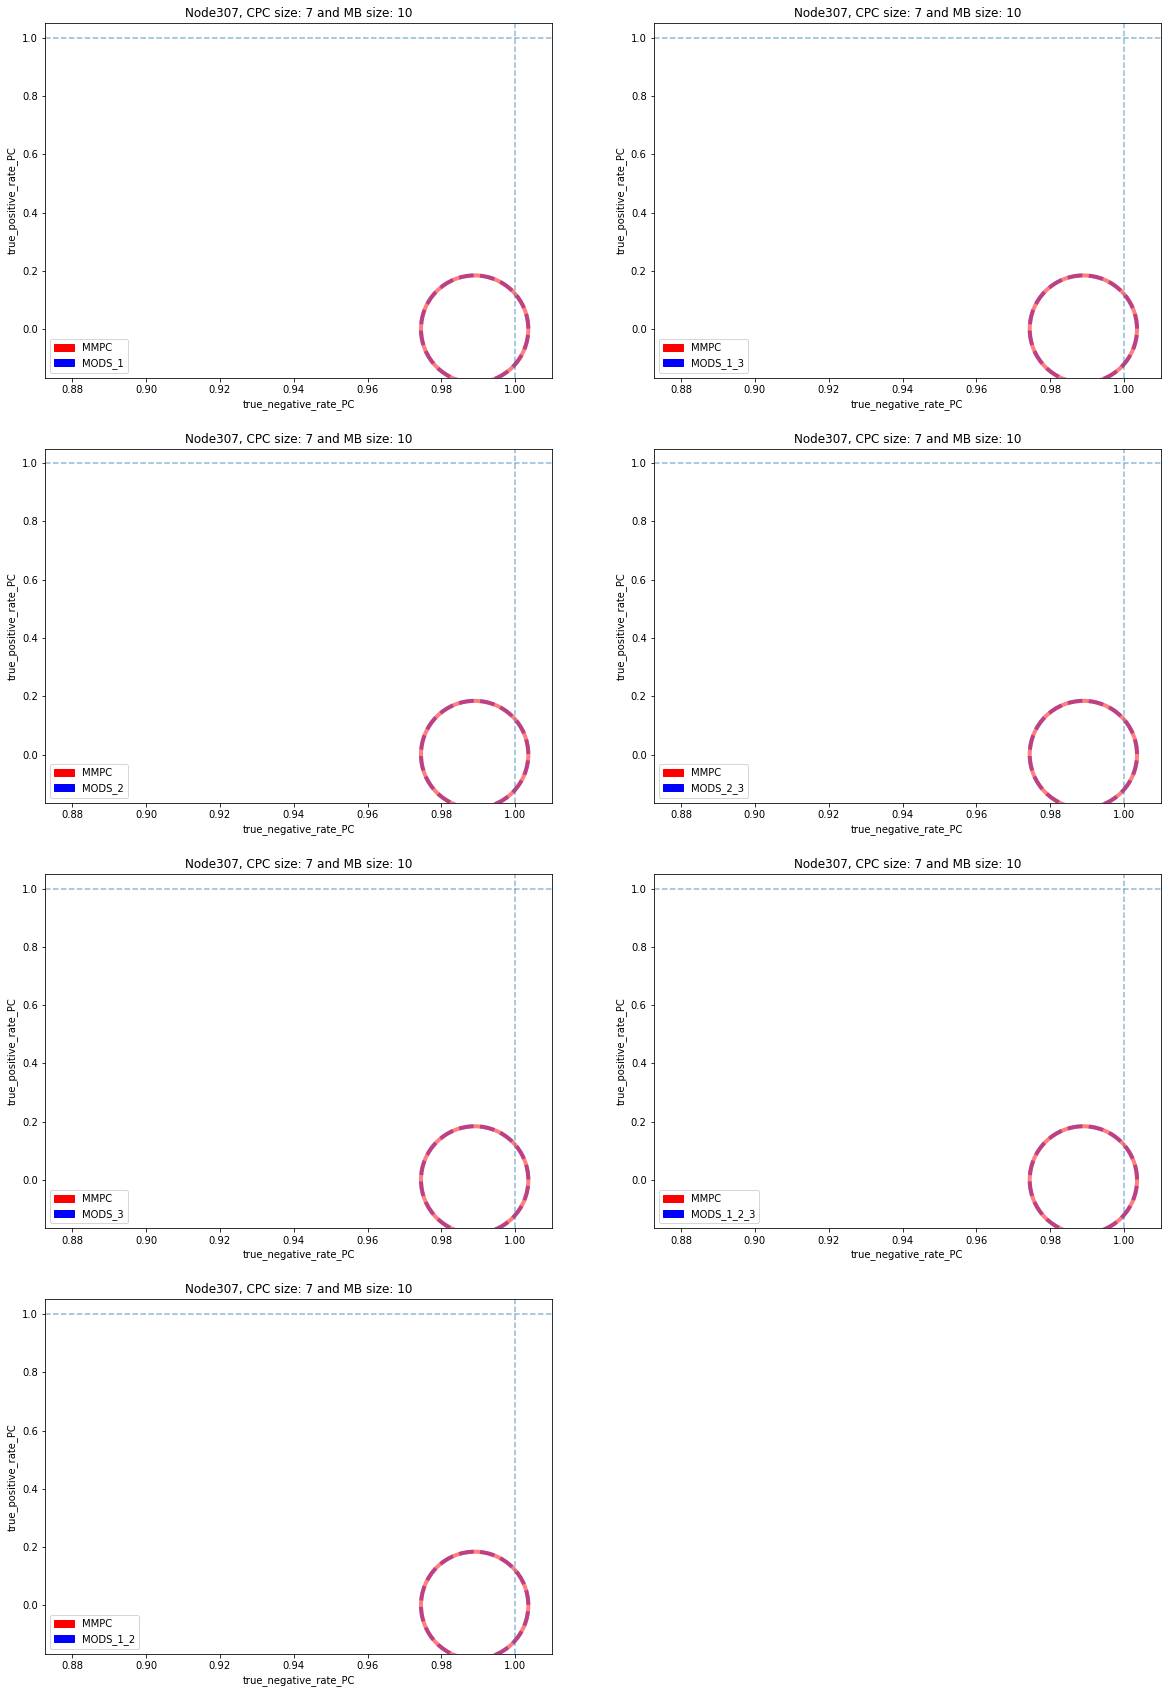

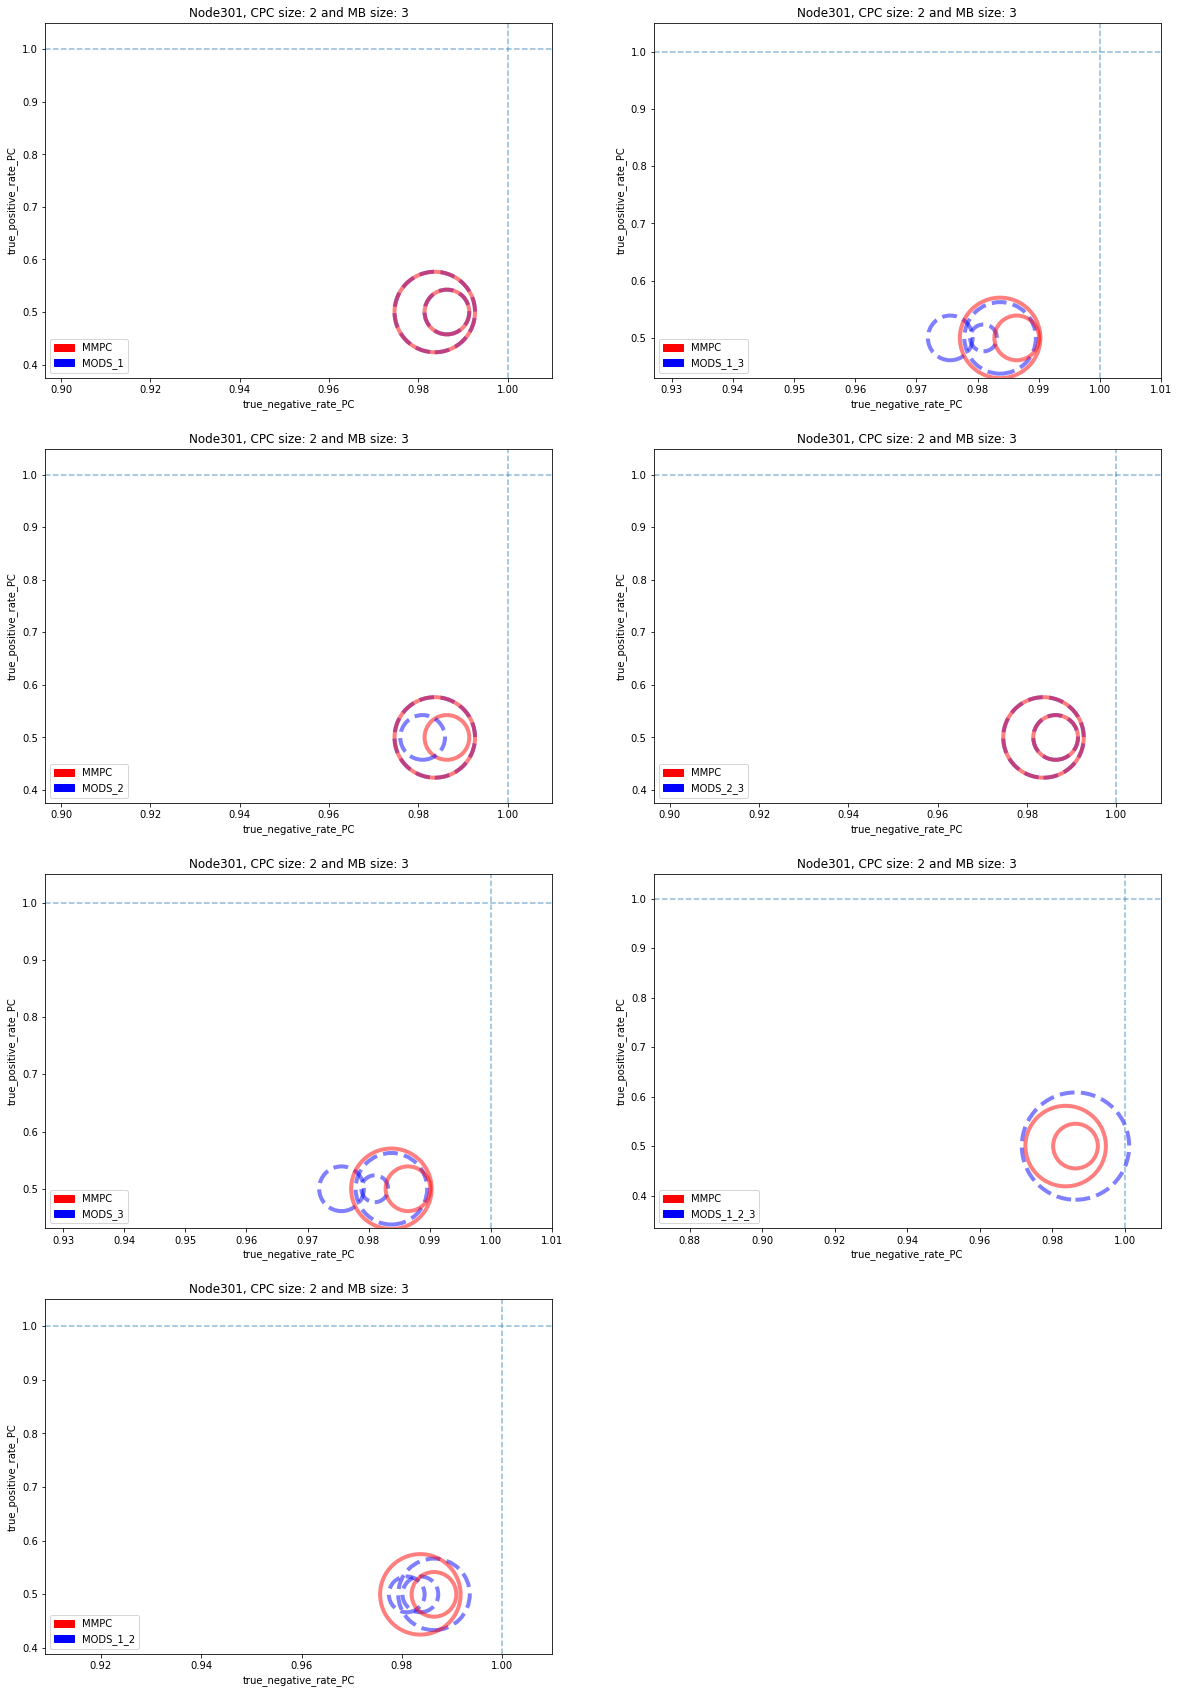

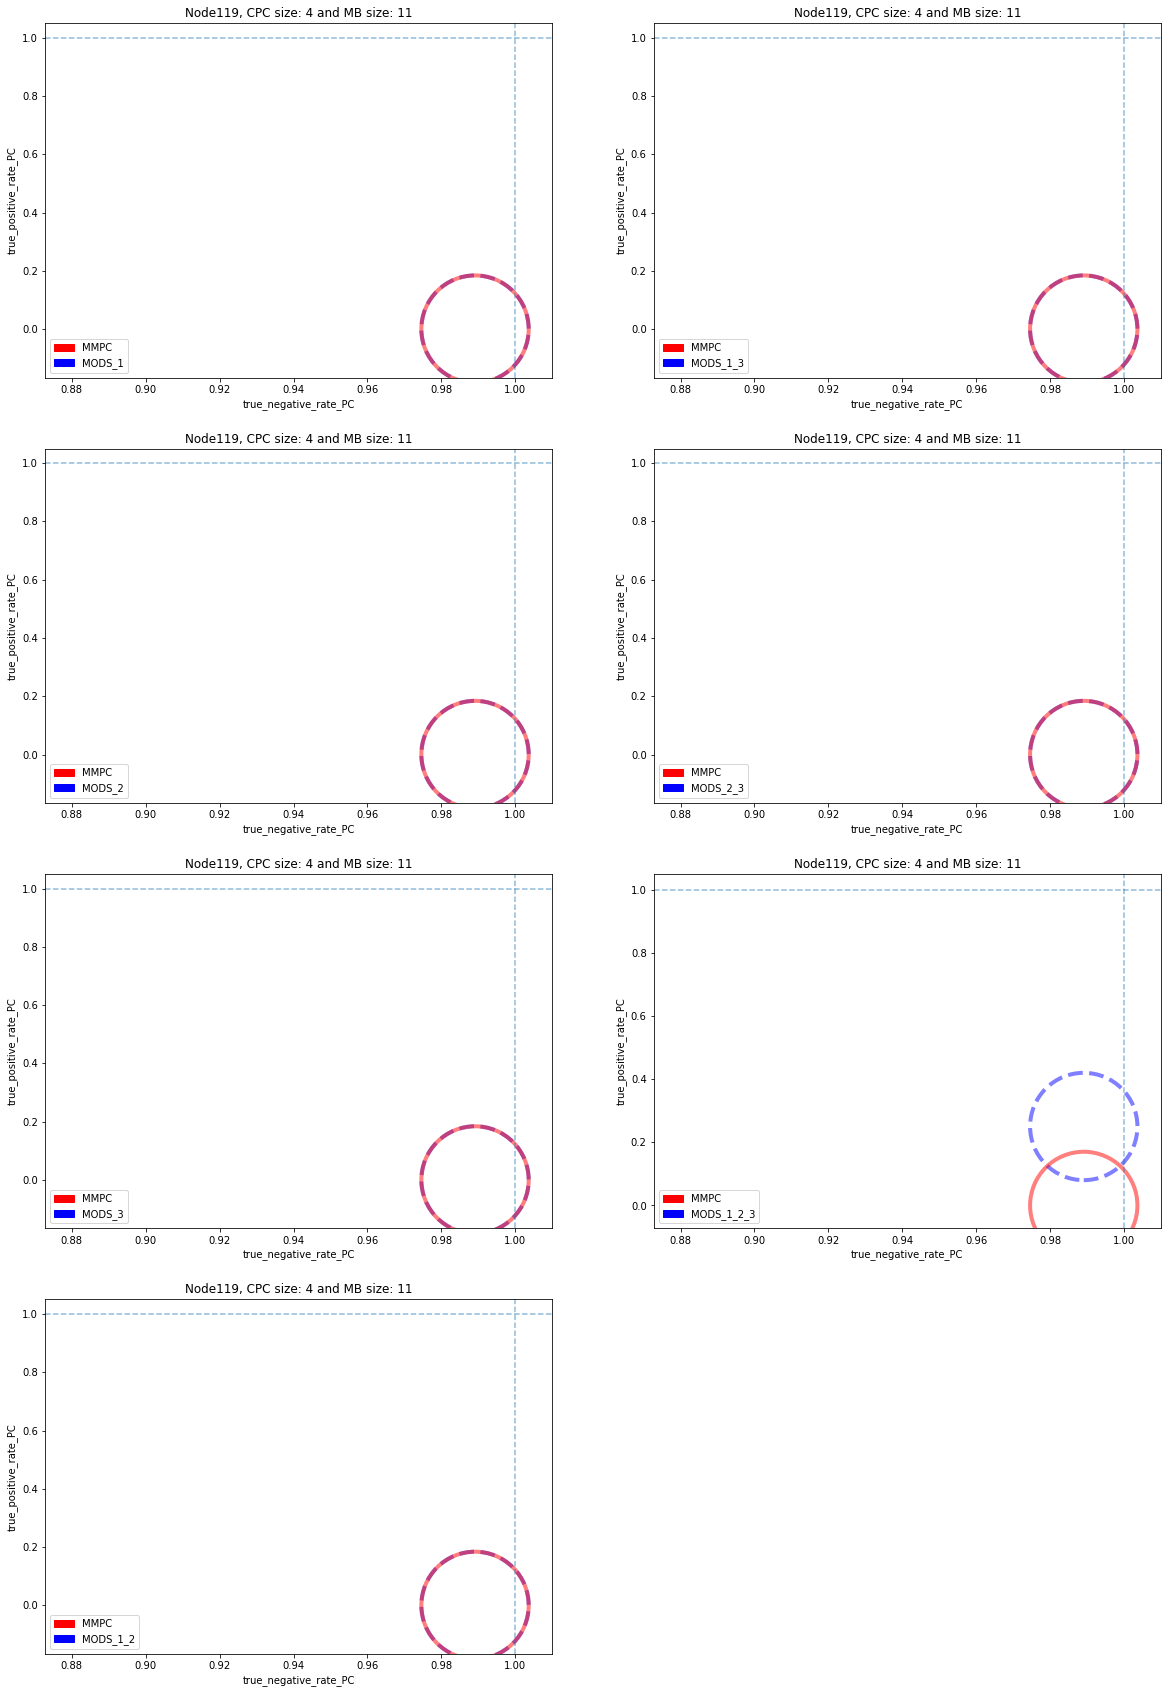

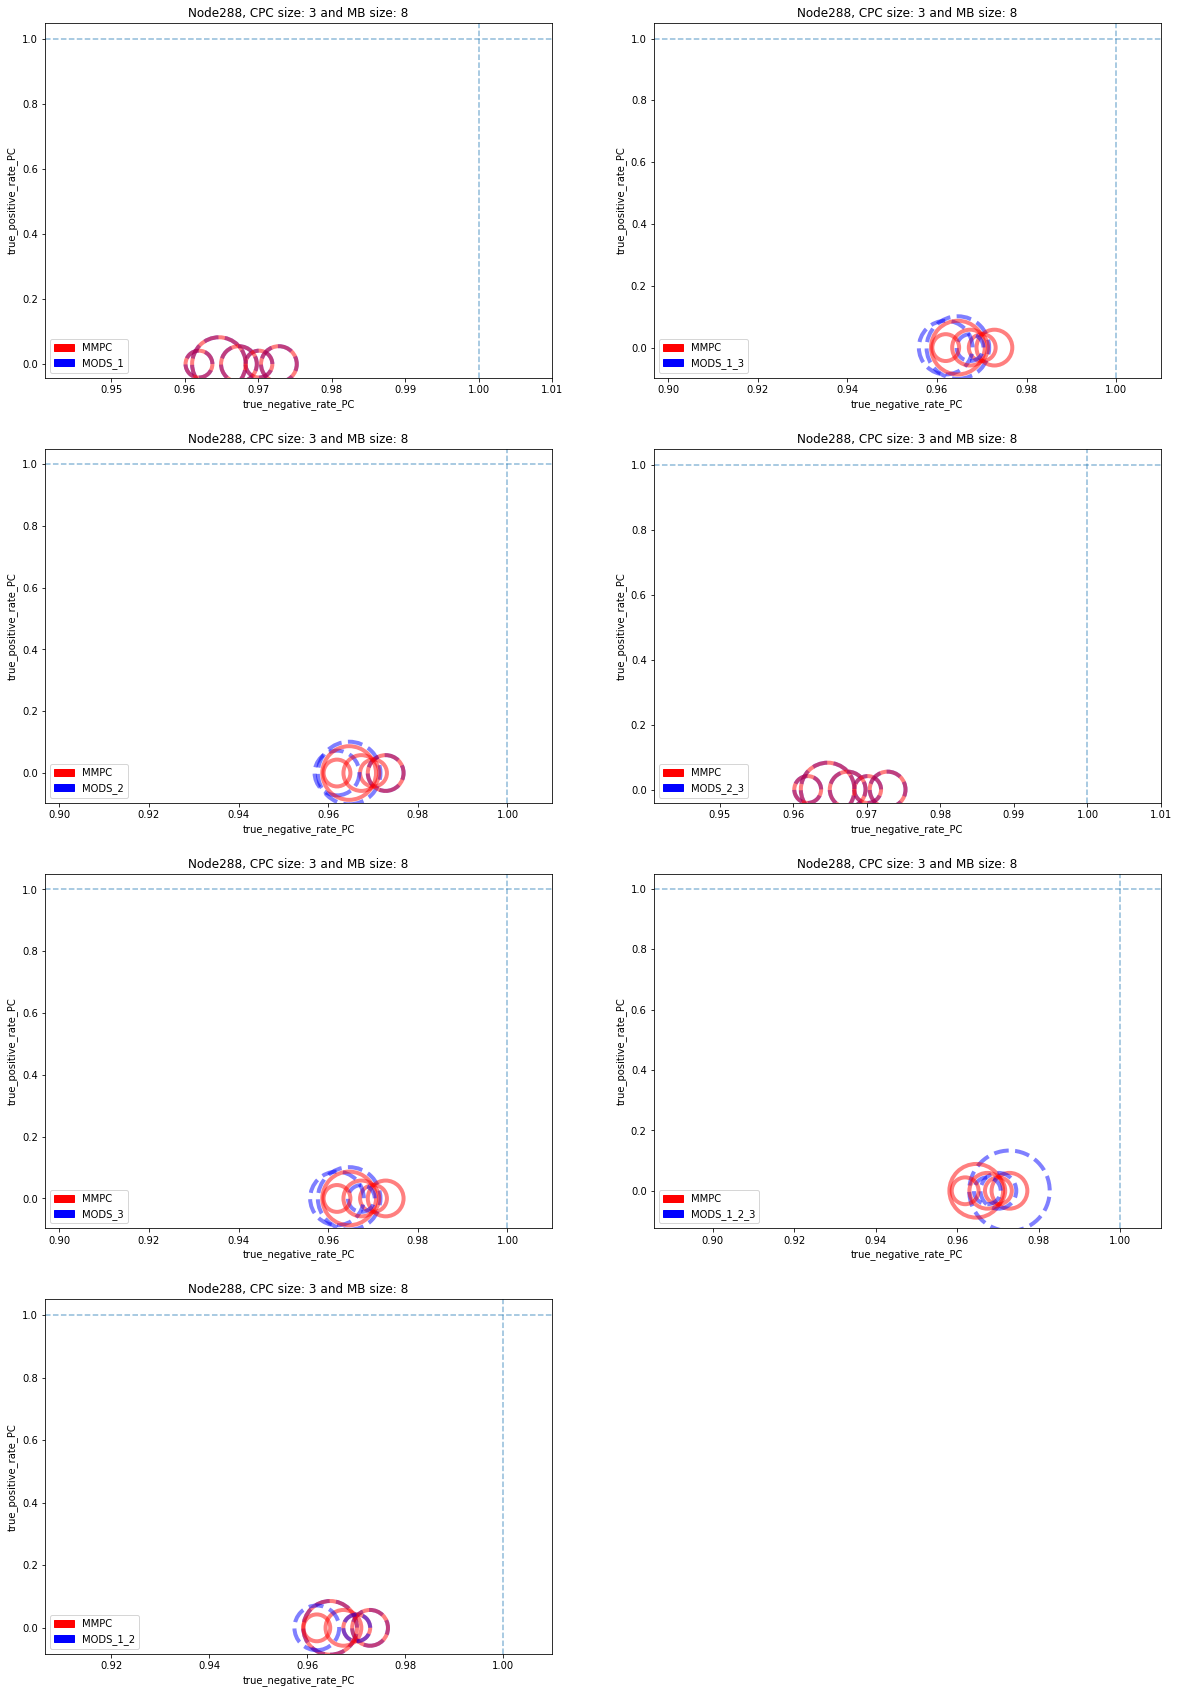

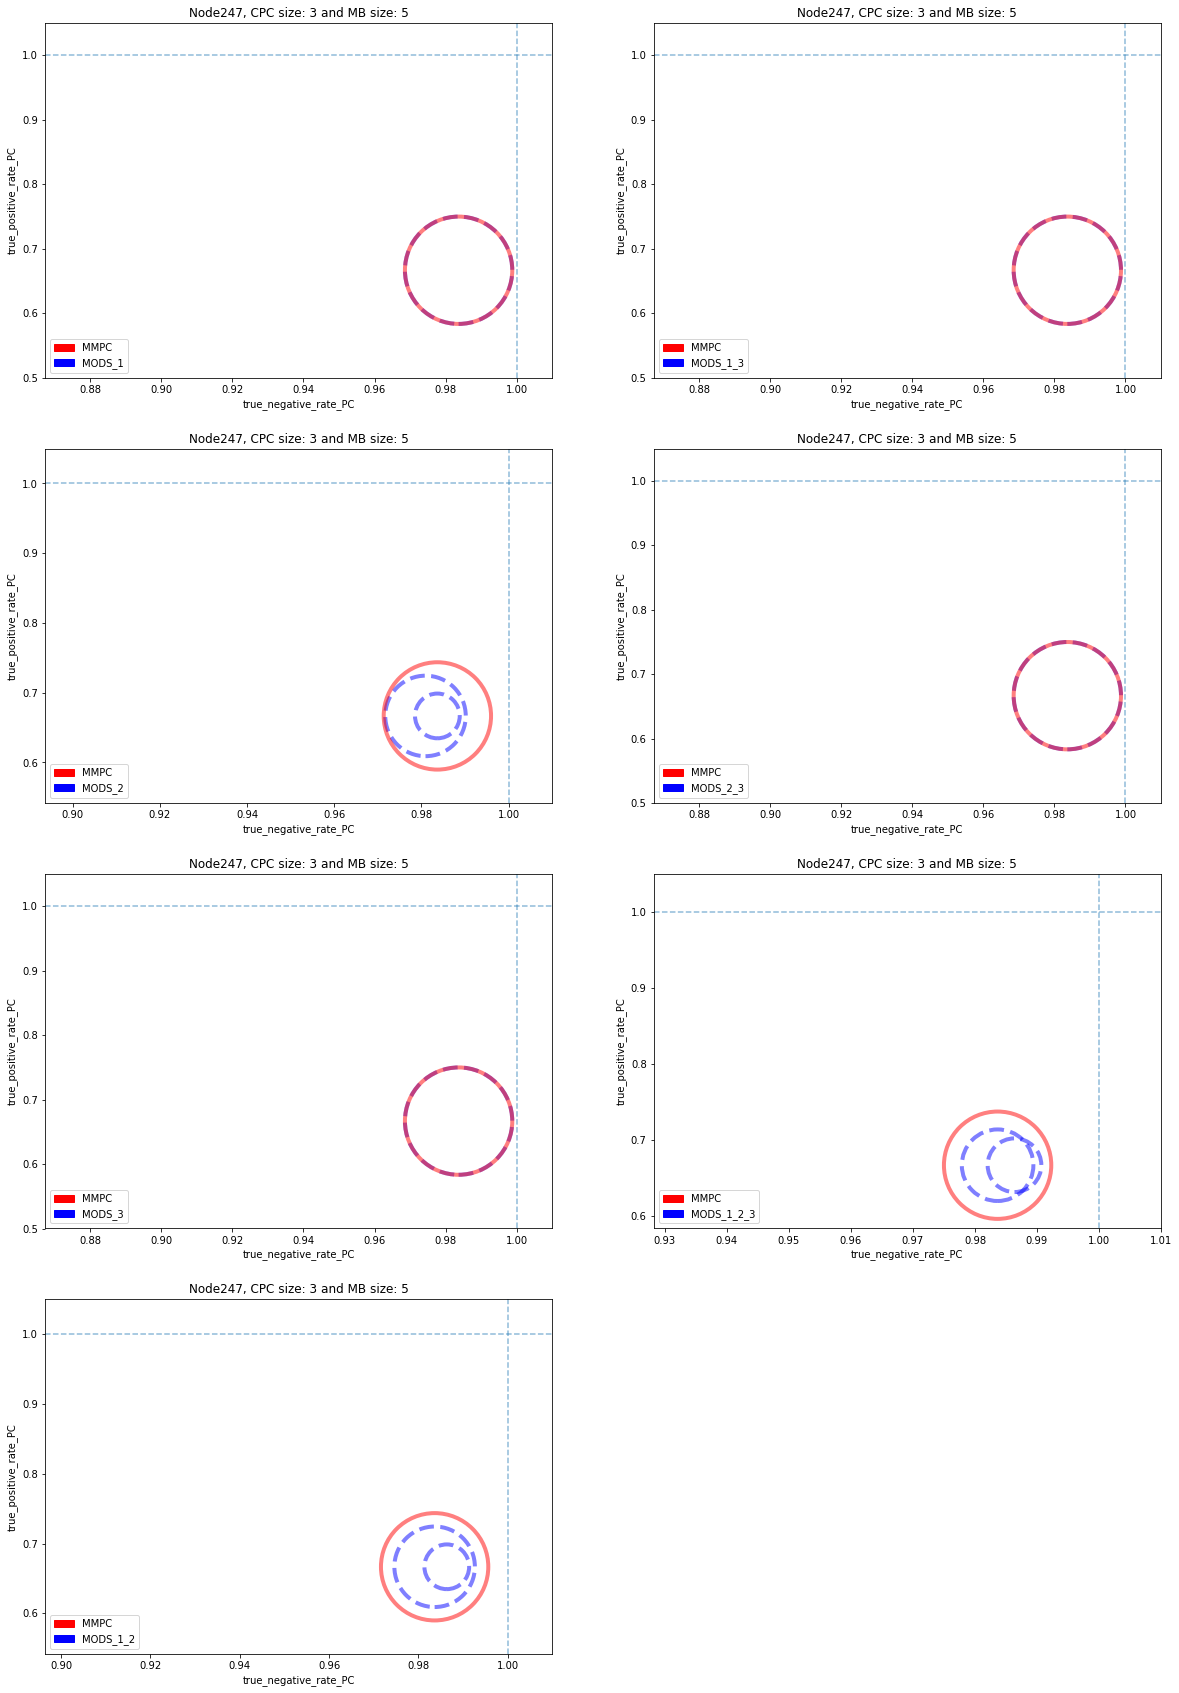

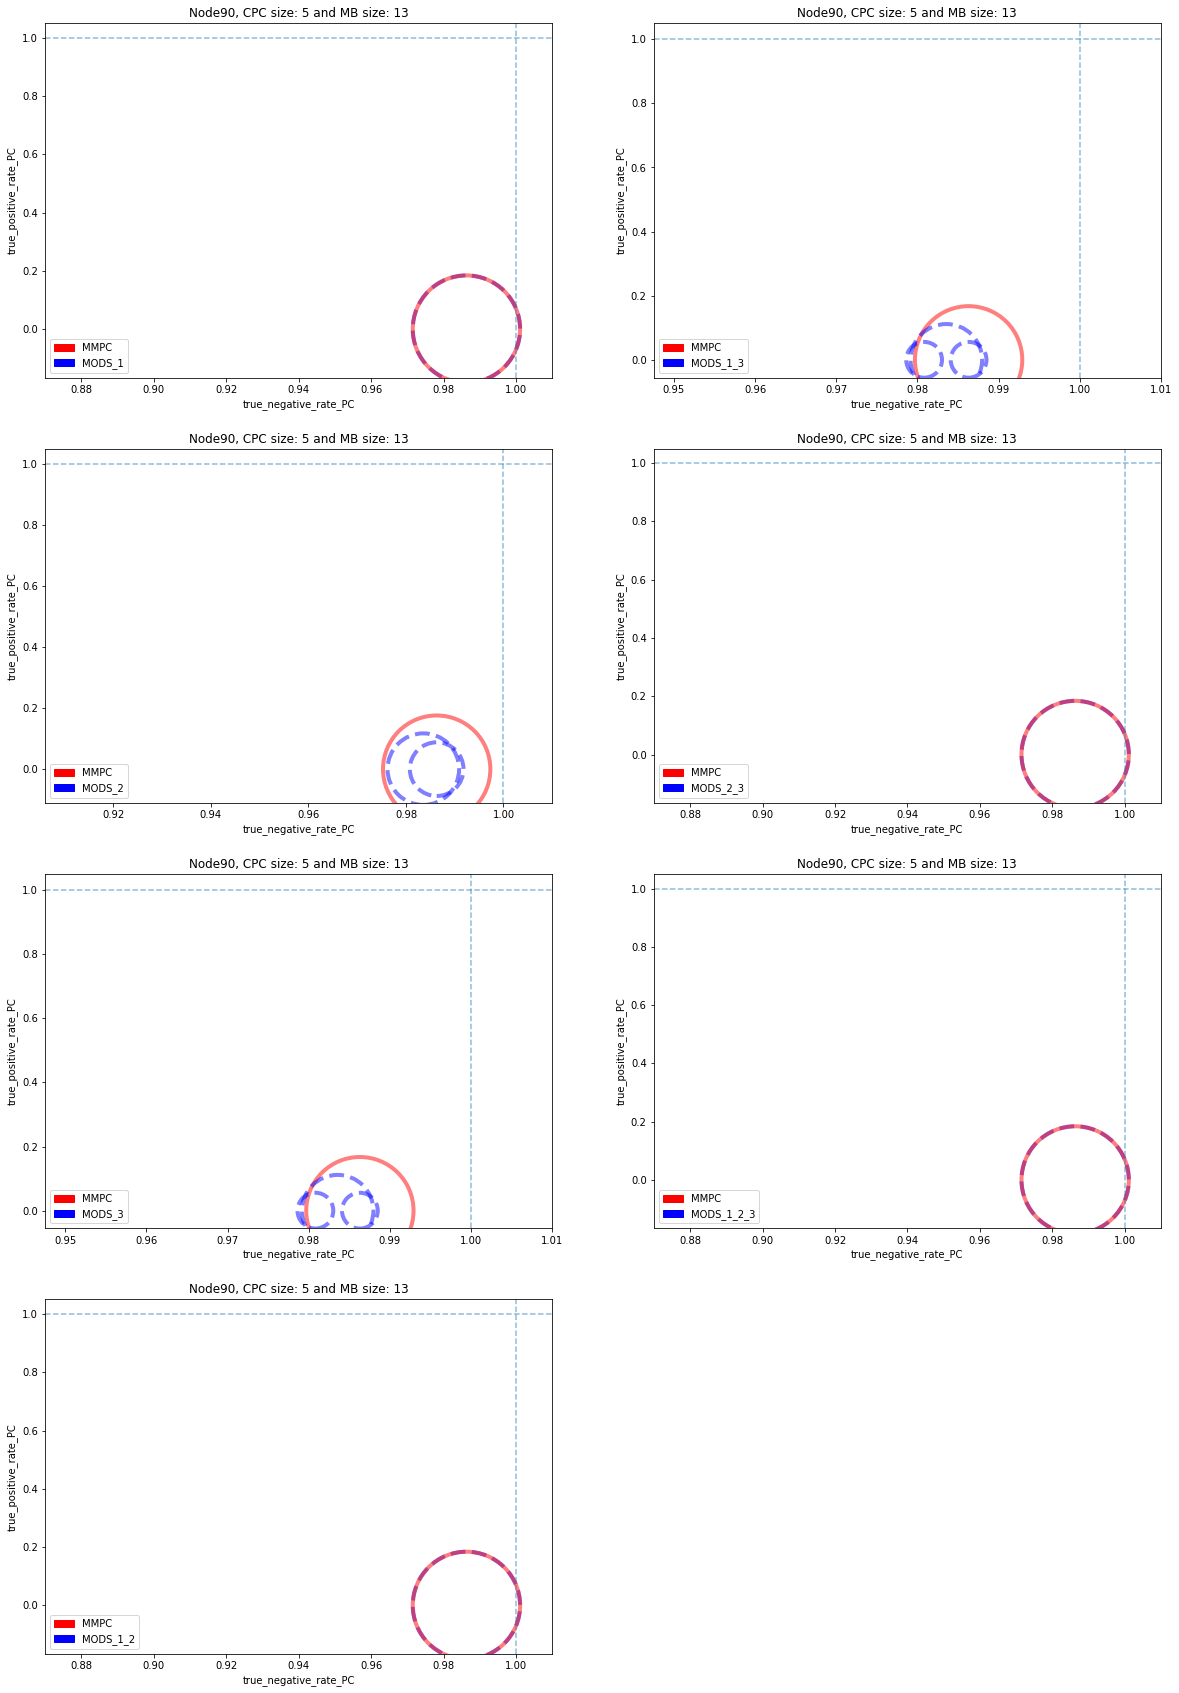

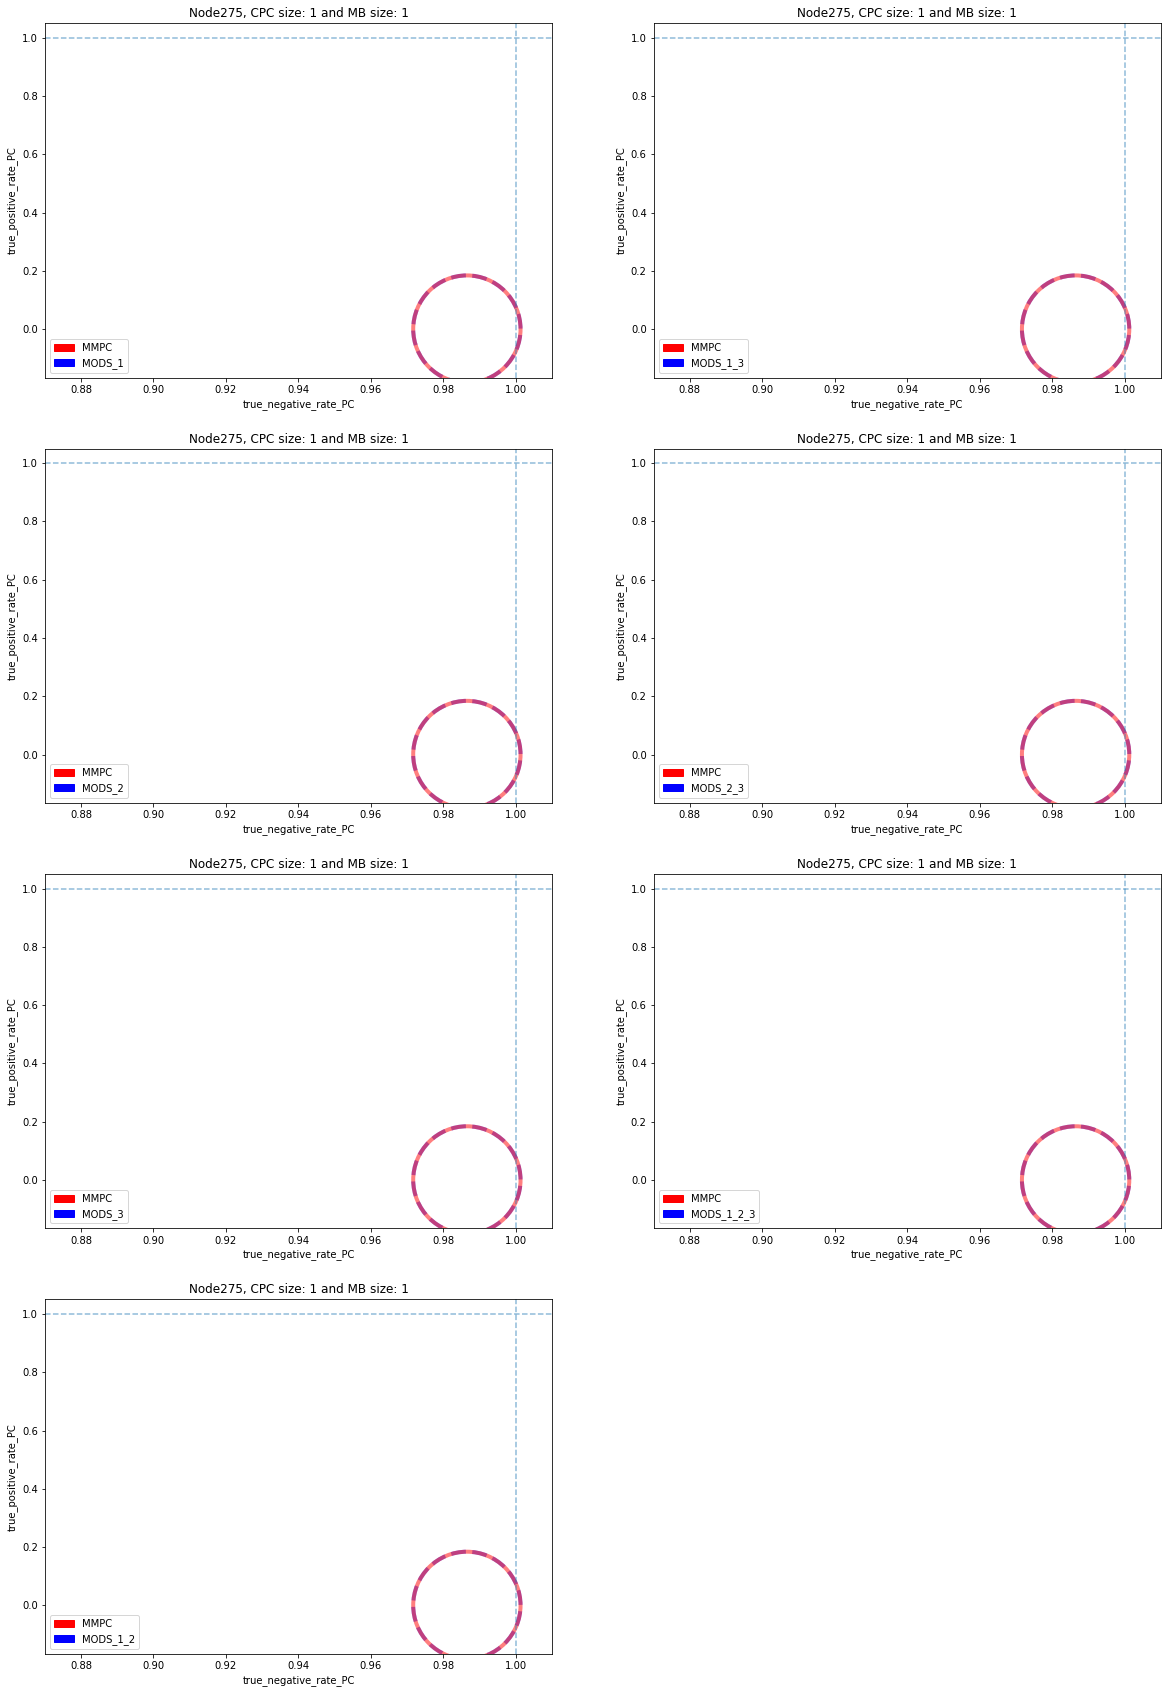

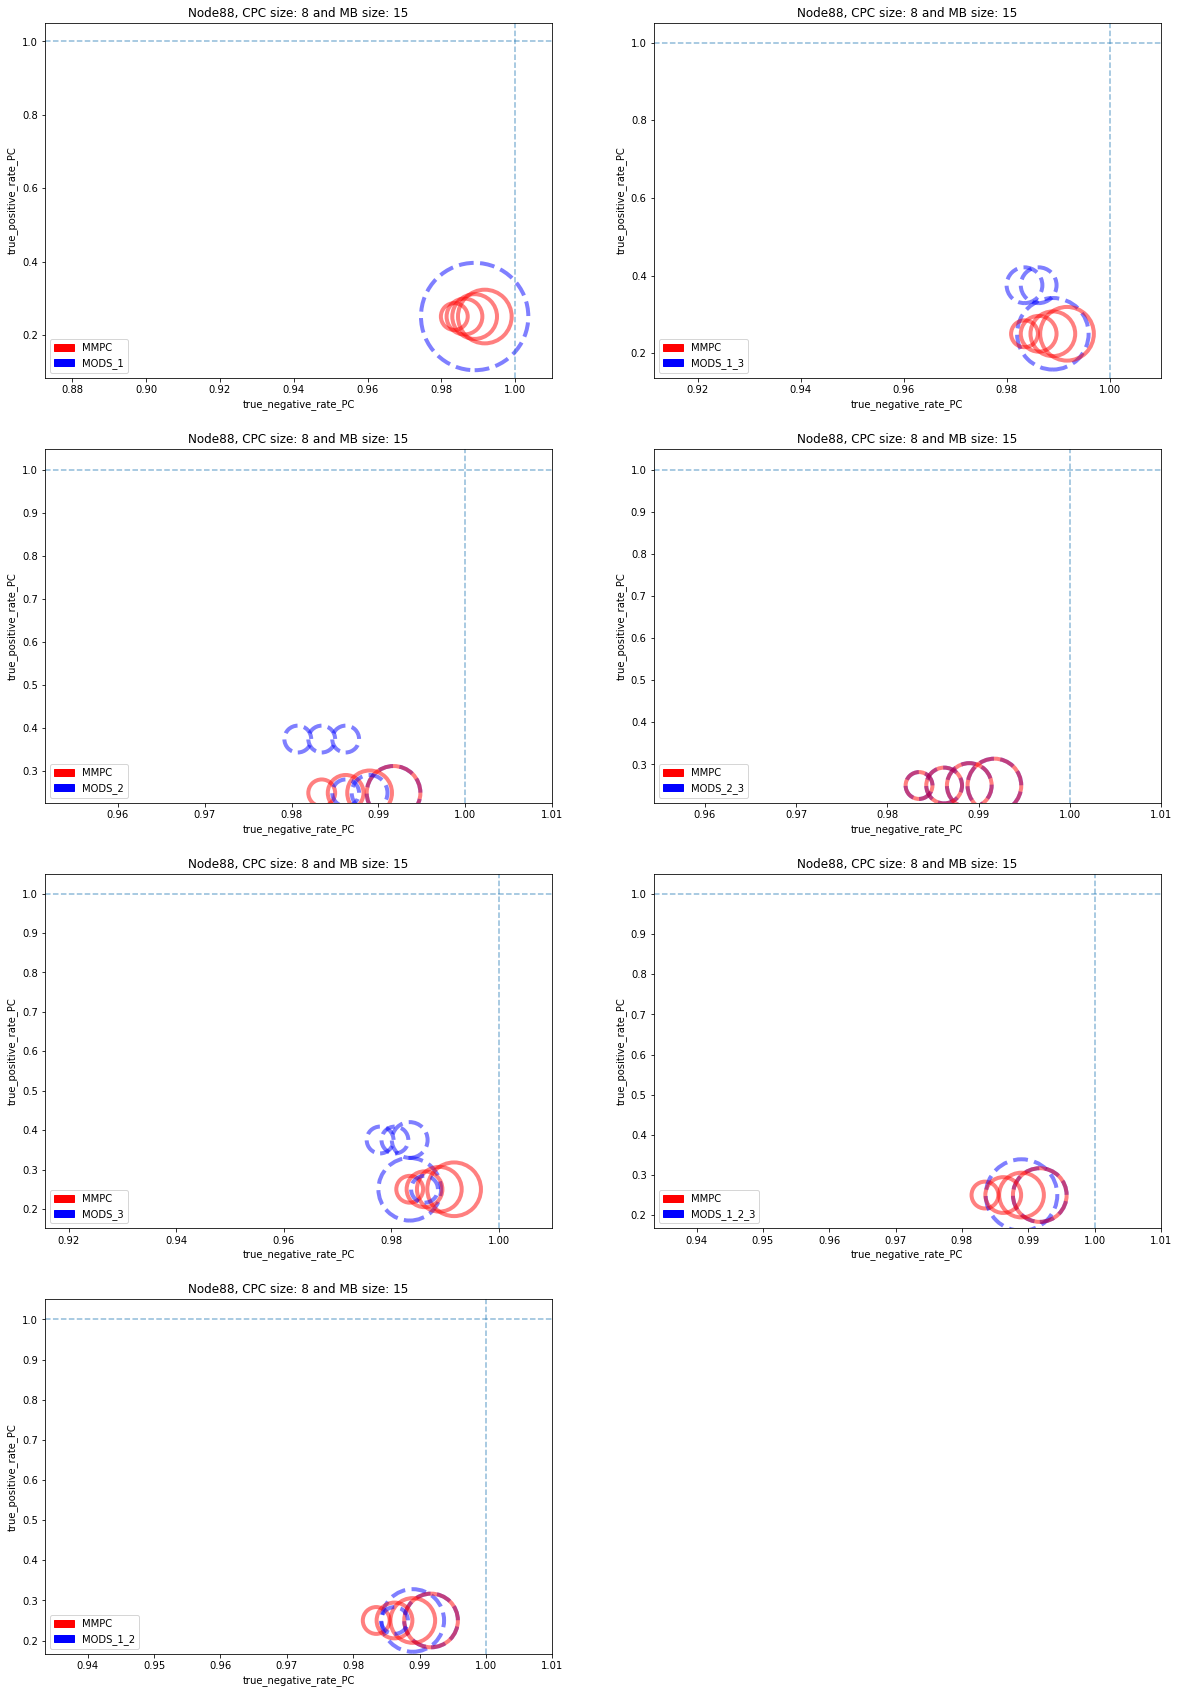

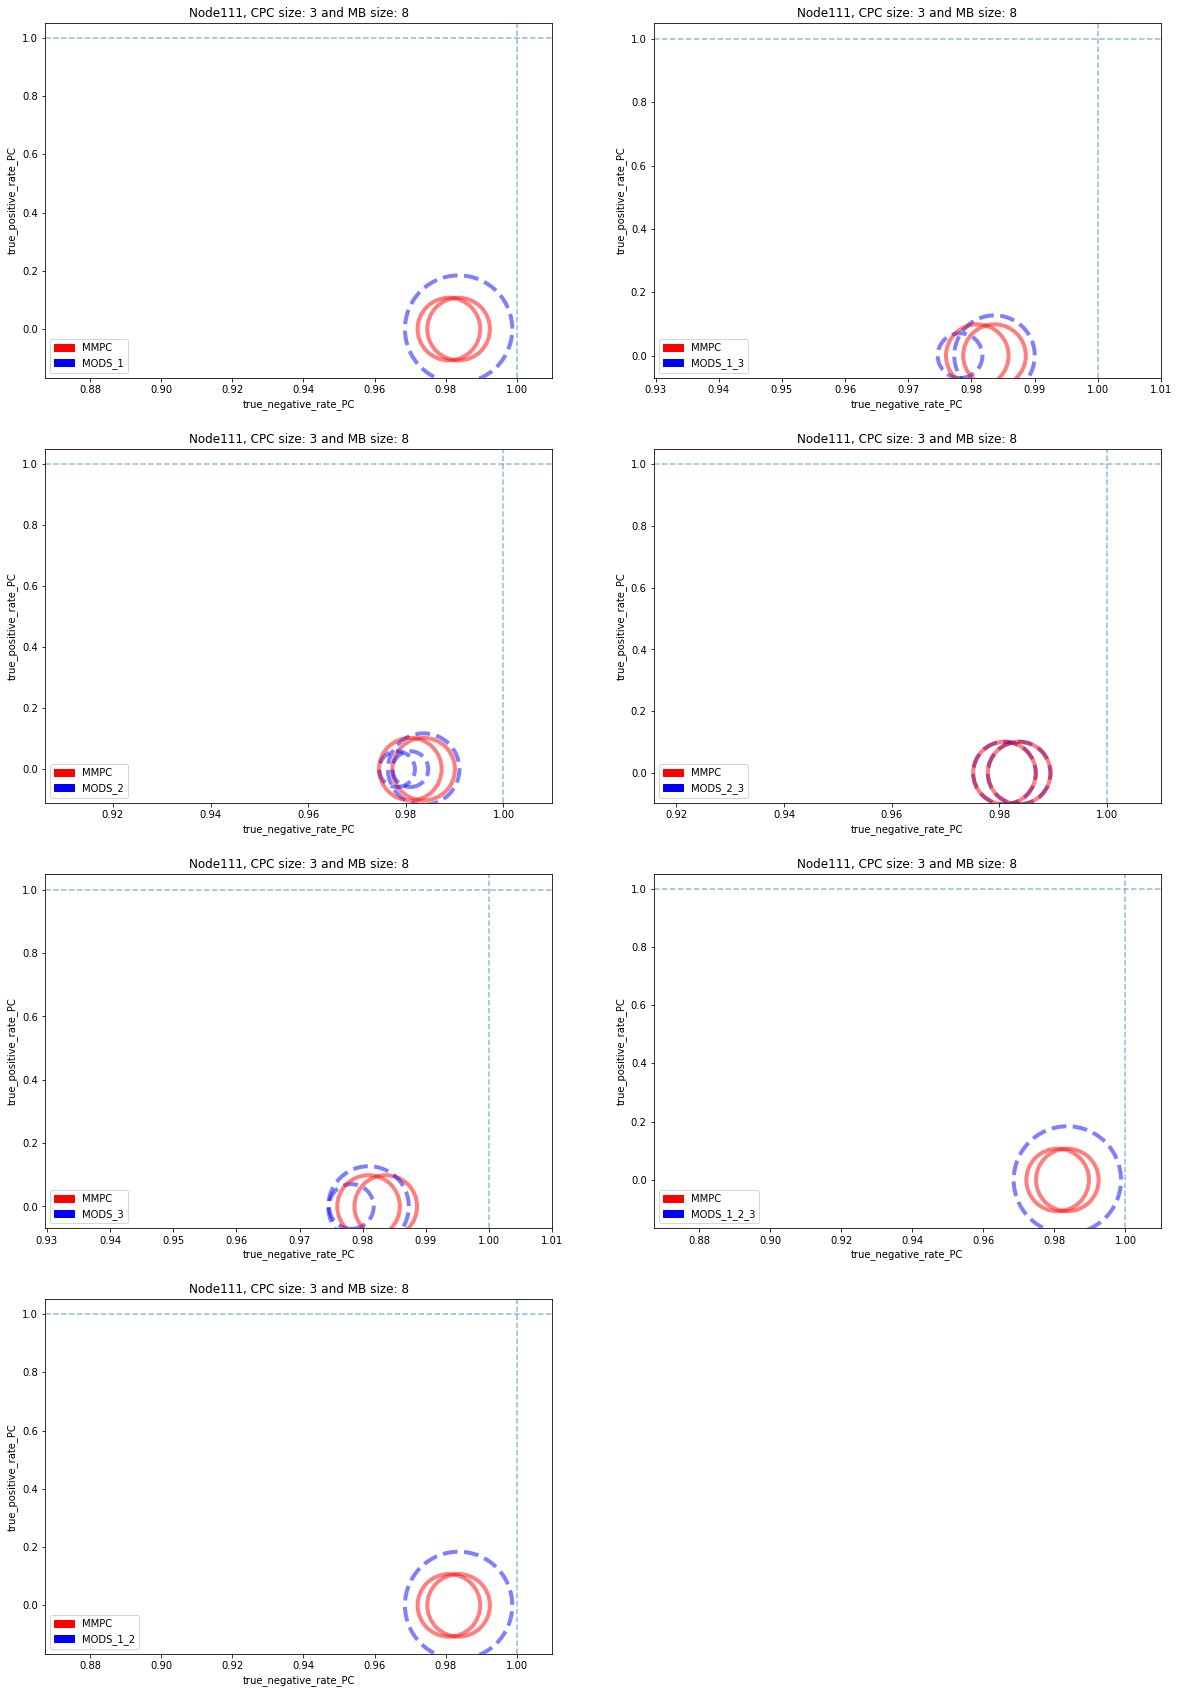

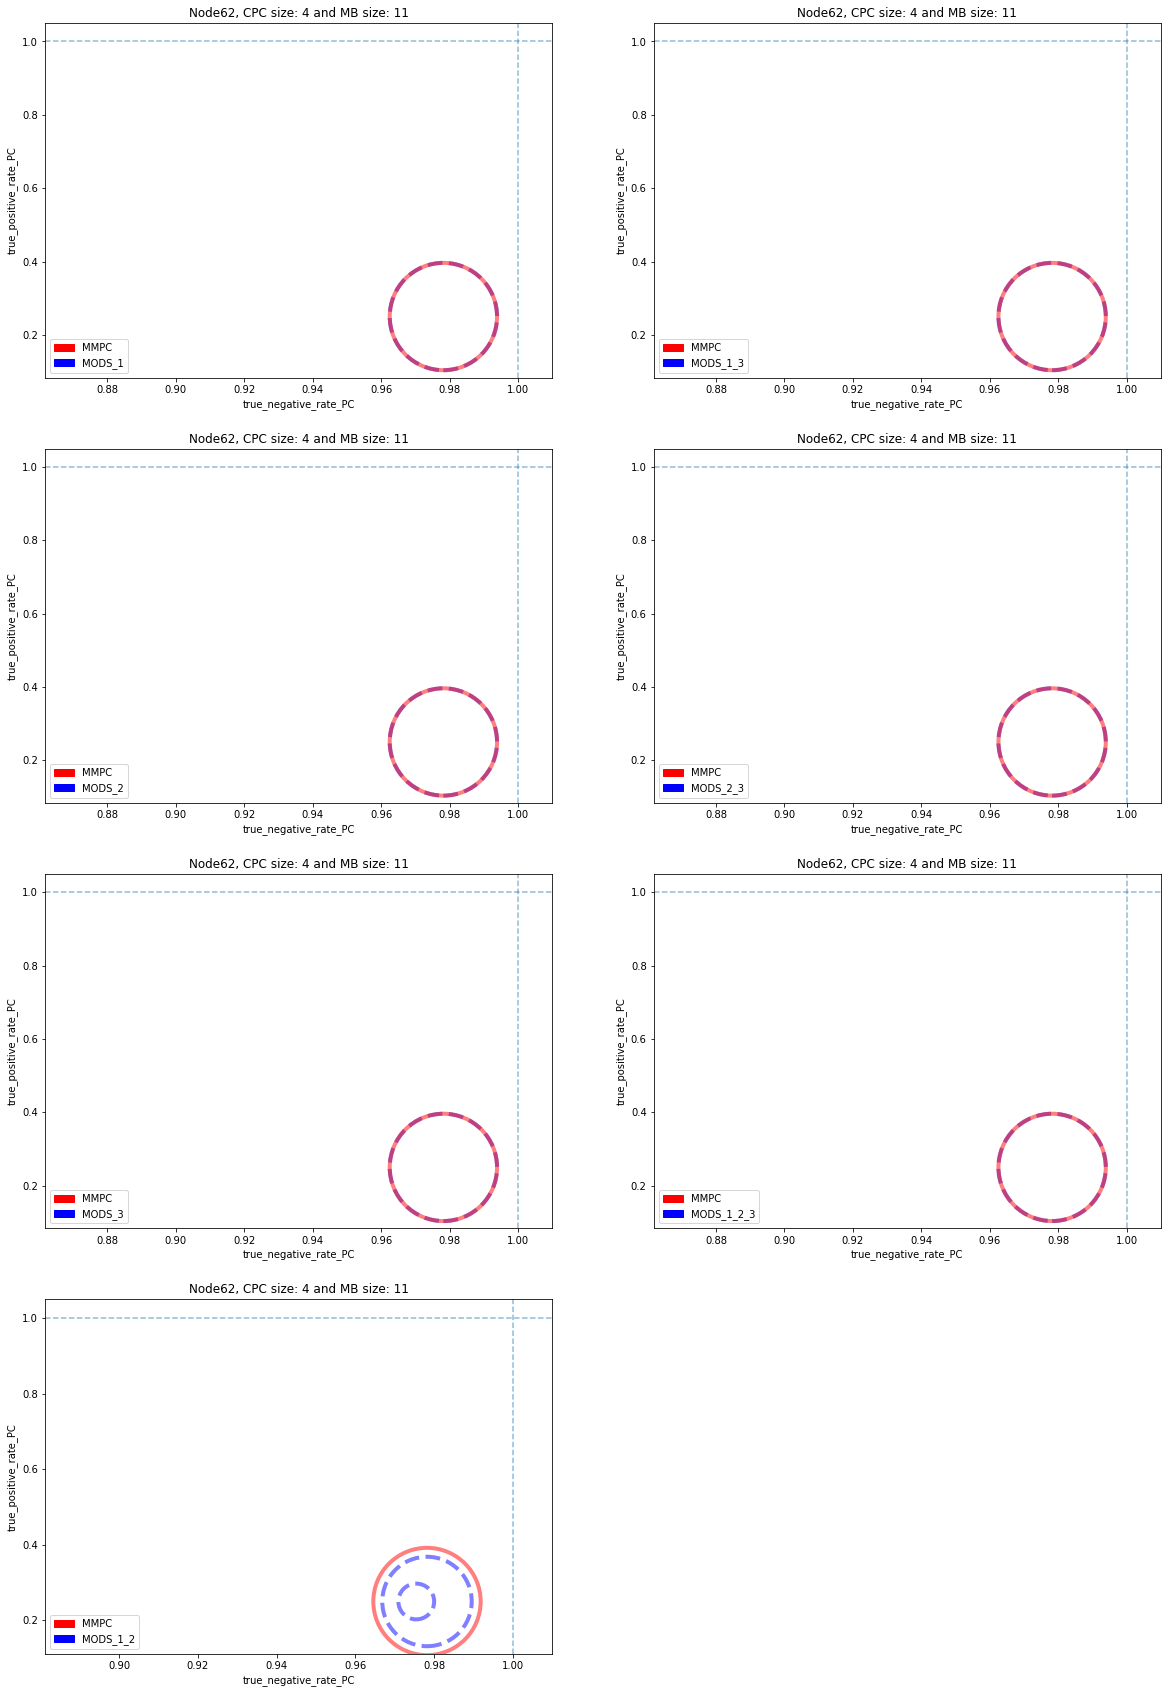

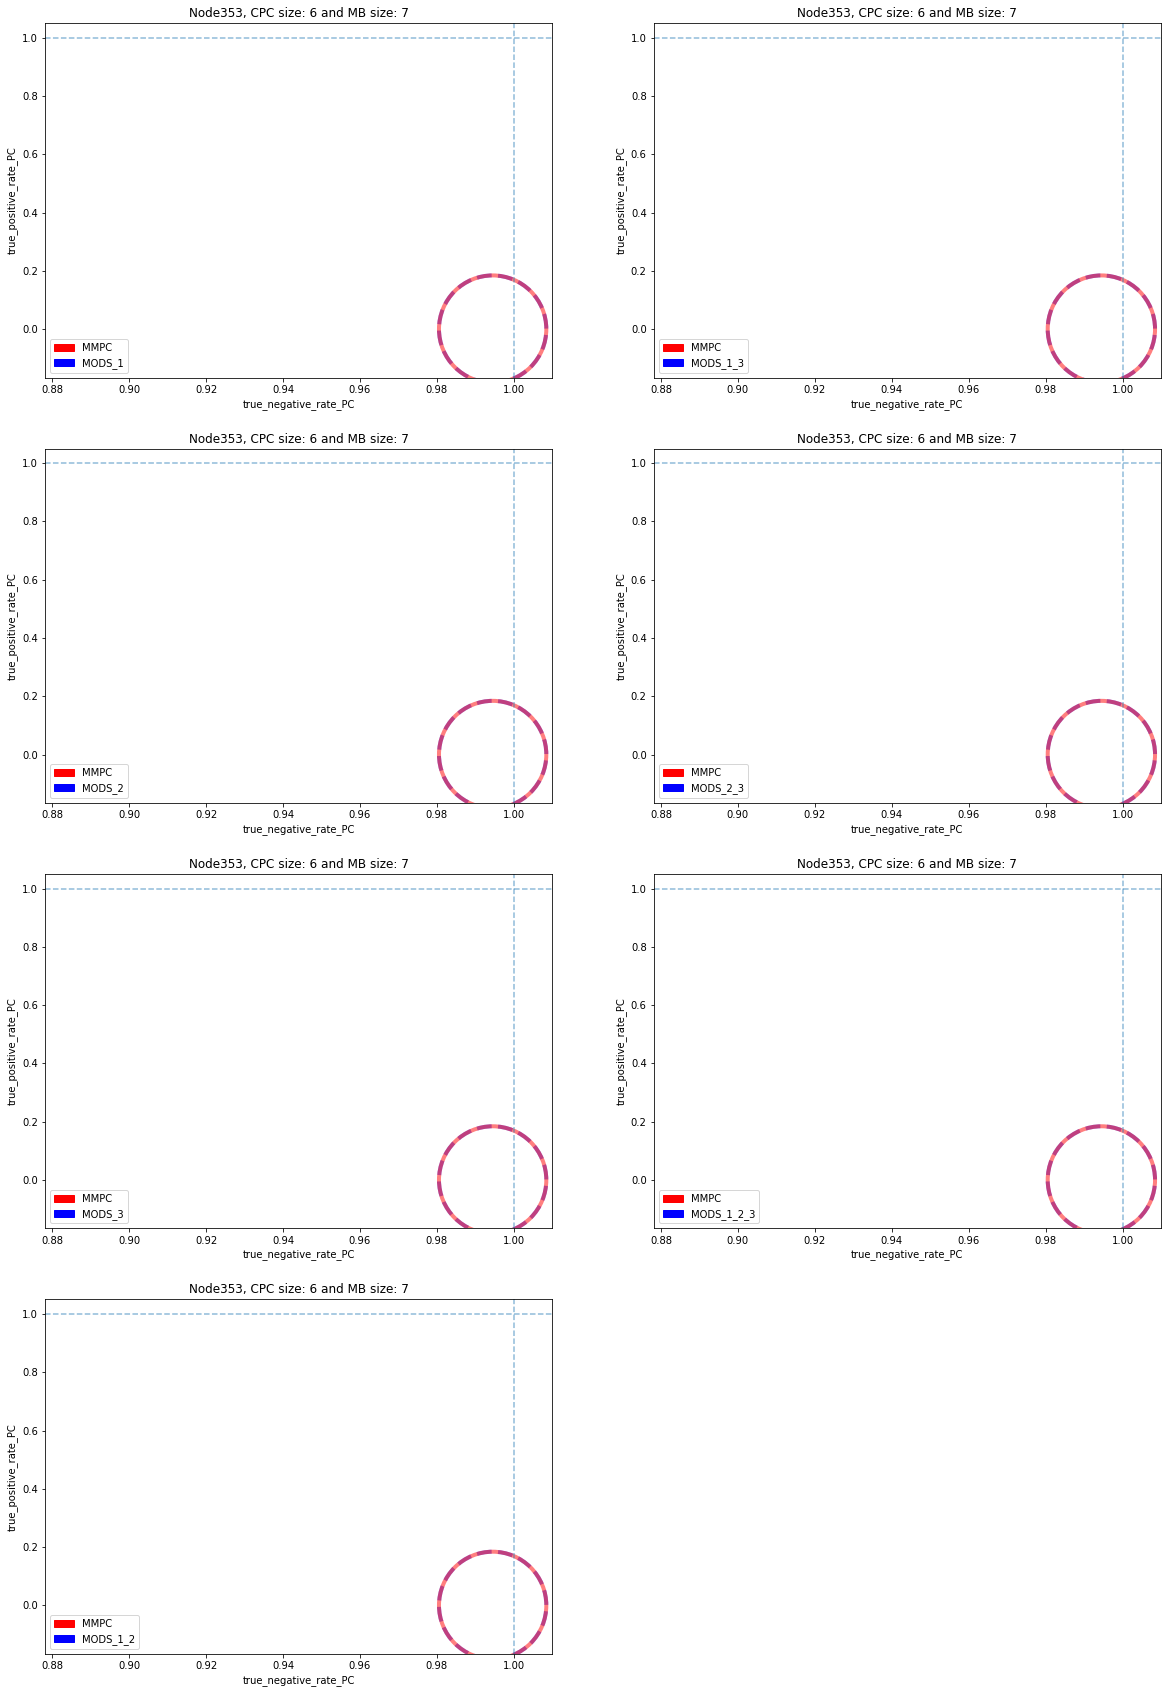

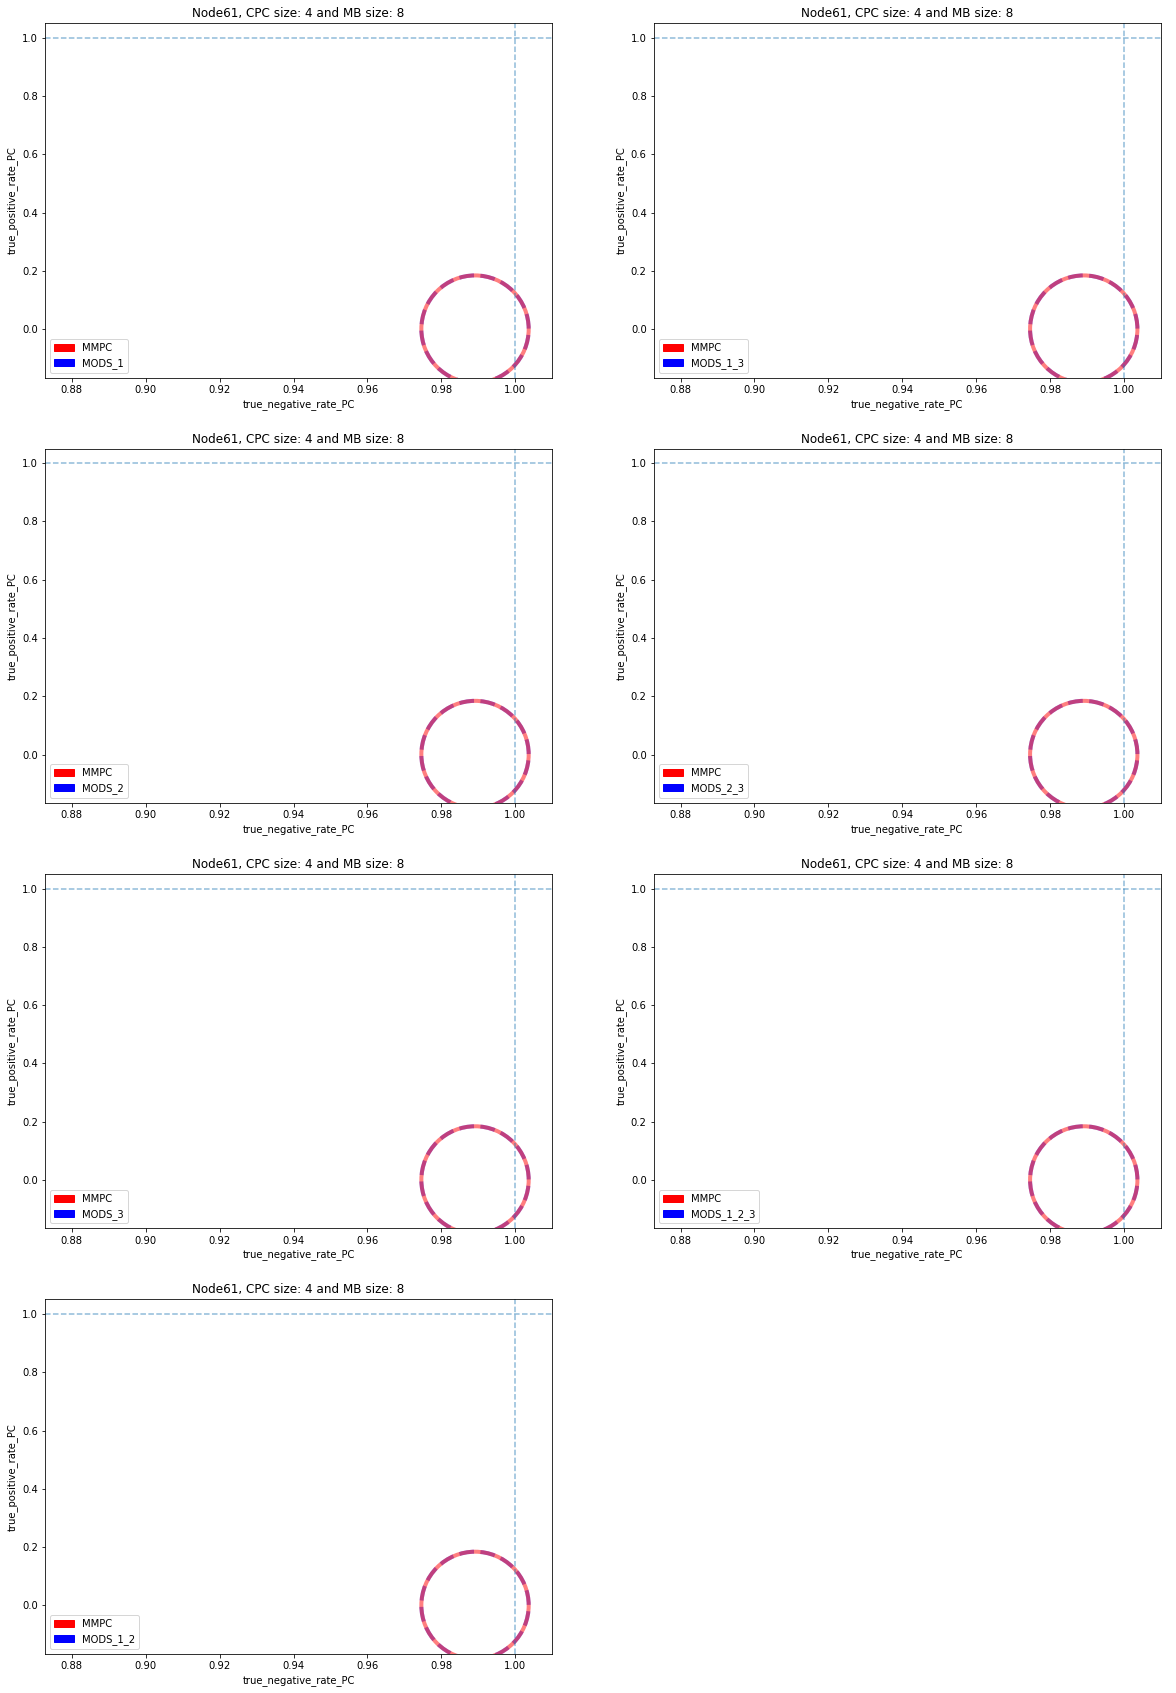

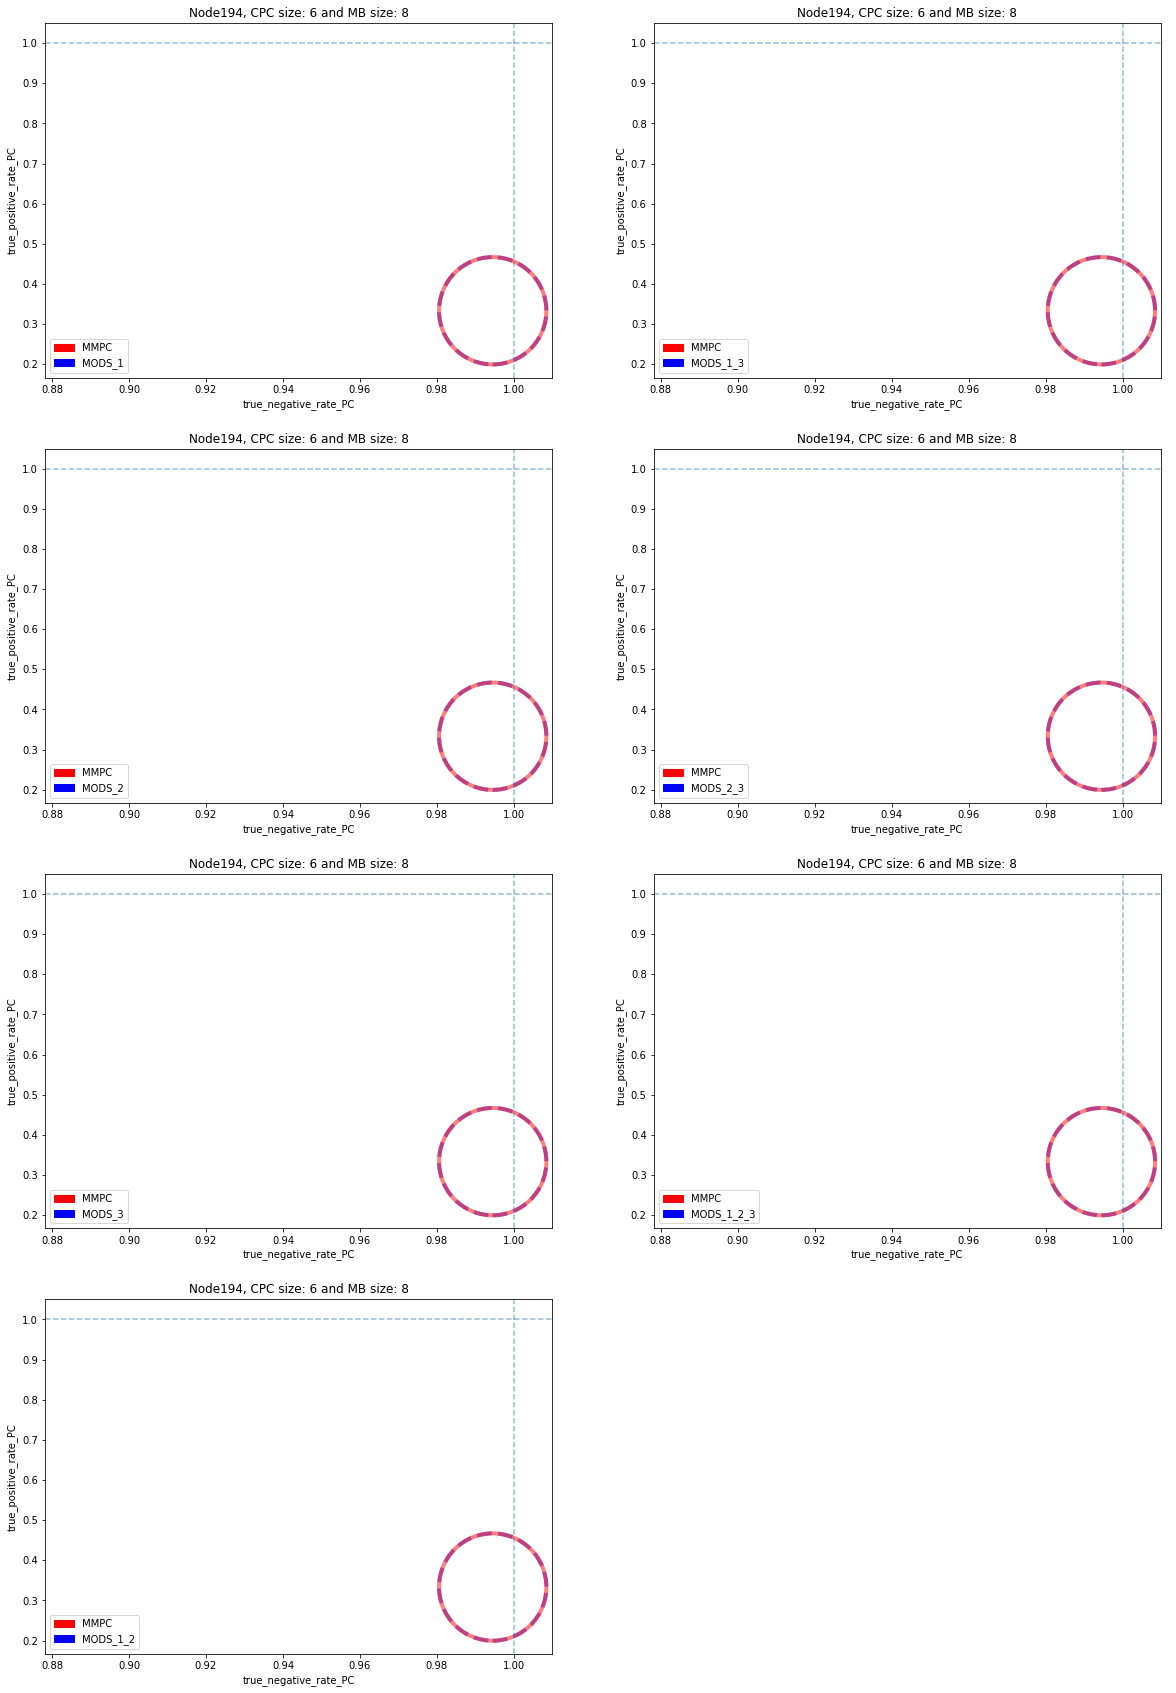

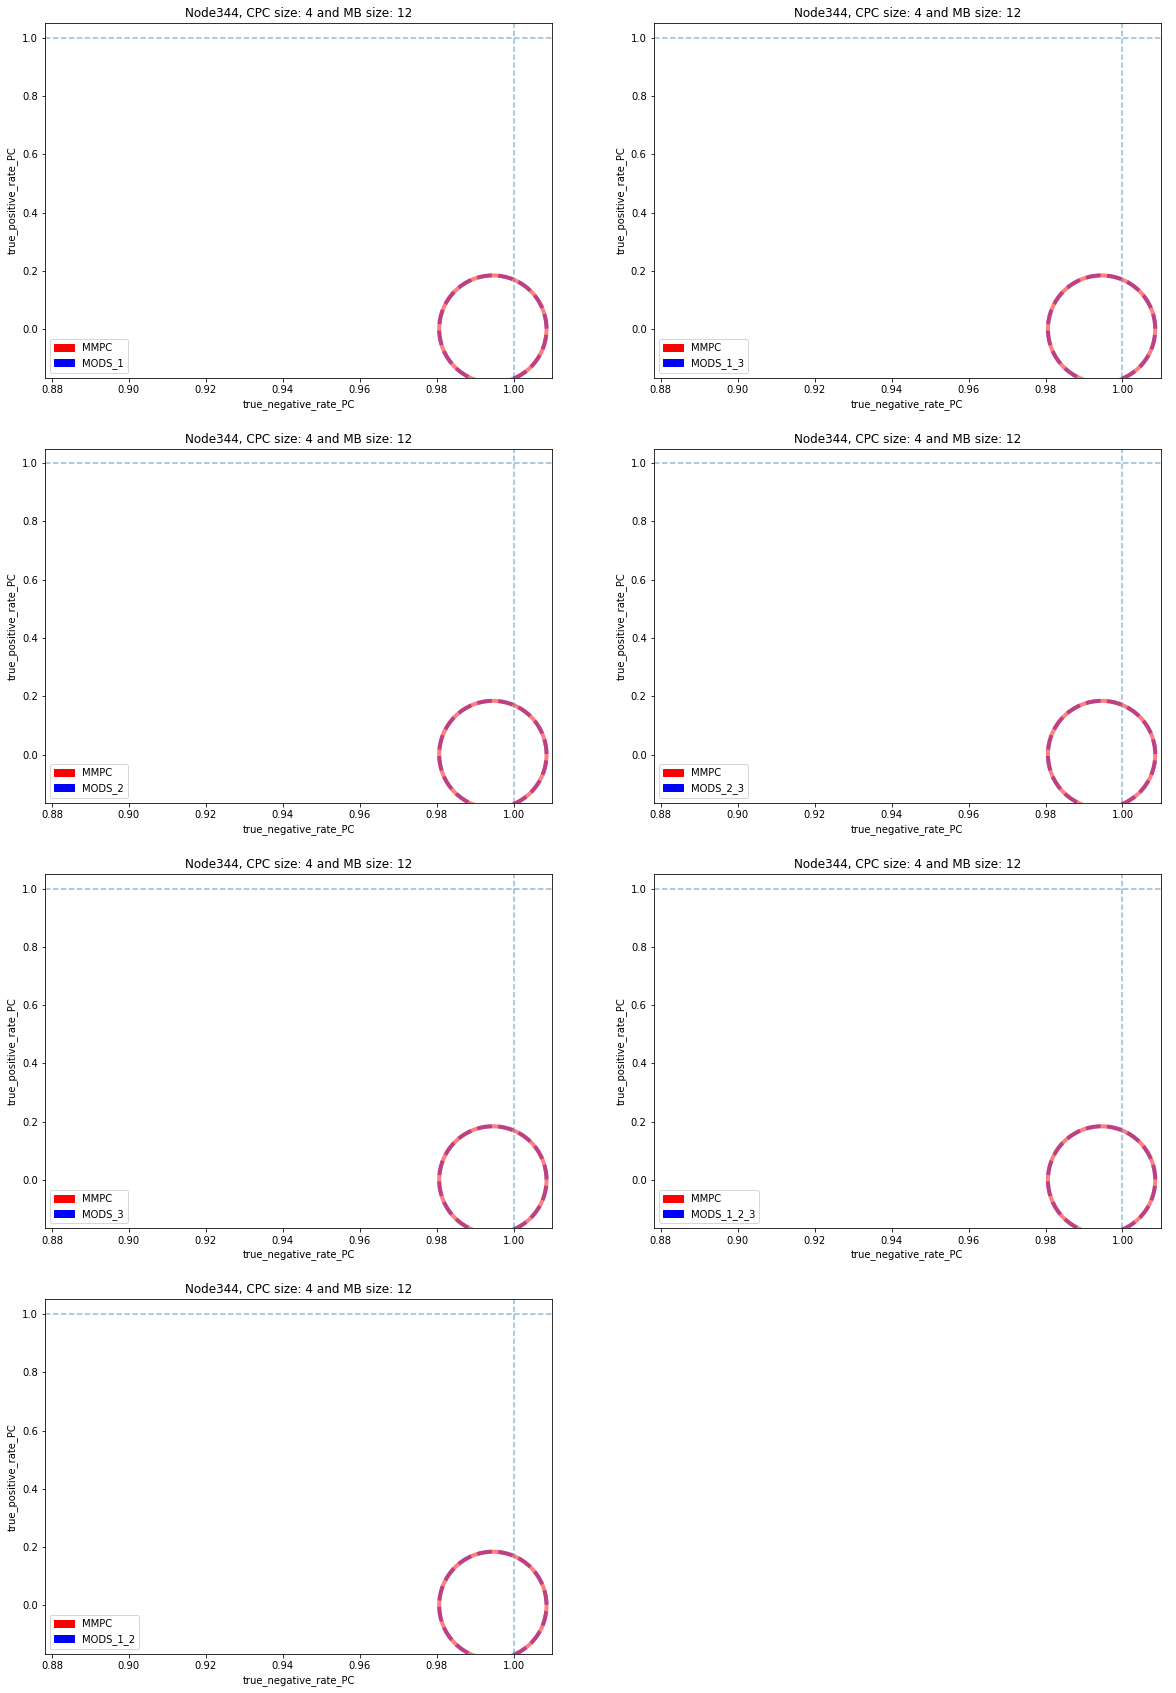

In [207]:
import seaborn as sns
# df_scored_results[df_scored_results['target']=='Node30'].plot.scatter(x='true_positive_rate_PC',y='true_negative_rate_PC')
import itertools
mks = ['o', 'o']
# markers = [next(mks) for i in df_scored_results["method"].unique()]
#color_map = dict(zip(filtered_df["method"].unique(), rgb_values))
for node in random_nodes:
    fig, axes = plt.subplots(4,2,figsize=(20,30))
    counter = 0
    for method in method_keys[1:]:
        j_plot = counter//4
        i_plot = counter%4
        #axes[i_plot,j_plot].plot()
        counter+=1
        node_name = 'Node'+str(node+1)
        filtered_df = df_scored_results[df_scored_results['target']==node_name]
        filtered_methods = ['MMPC',method]
        filtered_df = filtered_df[(filtered_df["method"]=='MMPC') | (filtered_df["method"] == method) ]
        rgb_values = sns.color_palette("Set2", 8)
        color_map = dict(zip(filtered_df["method"].unique(), rgb_values))
        # markers = [next(mks) for i in filtered_df["method"].unique()]
        markers ={
            filtered_methods[0]:mks[0],
            filtered_methods[1]:mks[1]
        }
        # sns.pairplot(y_vars=["true_positive_rate_PC"], x_vars=["true_negative_rate_PC"], data=filtered_df, hue="method",plot_kws={"s": 200},markers=markers, size=5)
        #melted_pd = pd.melt(filtered_df[["method","true_negative_rate_PC","true_positive_rate_PC"]], "method", var_name=node_name,value_vars=["true_negative_rate_PC","true_positive_rate_PC"])
        #sns.swarmplot(x=node_name,y="value",hue="method",data=melted_pd,ax=axes[i_plot,j_plot],size=5)
        #sns.scatterplot(x="true_negative_rate_PC",y="true_positive_rate_PC",hue="method",style="method",data=filtered_df,markers=markers,ax=axes[i_plot,j_plot],s=200)
        set_q = set_quantities(filtered_df)
        #print(sum(set_q.values()))
        key_list = [key for key in set_q]
        
        for j in range(0,len(key_list)):
            key = key_list[j]
            supra_filtered_df = filtered_df[(filtered_df["true_negative_rate_PC"]==float(key.split(',')[0])) &(filtered_df["true_positive_rate_PC"]==float(key.split(',')[1]))]
            supra_filtered_df = supra_filtered_df[supra_filtered_df["method"]==key.split(',')[2]].drop_duplicates()
            # supra_filtered_methods = set([x[0] for x in supra_filtered_df[["method"]].values])
#             supra_markers = copy.deepcopy(markers)
#             supra_markers_keys = [key for key in supra_markers]
#             for k in range(len(supra_markers_keys)-1,-1,-1):
#                 if supra_markers_keys[k] not in supra_filtered_methods:
#                     del supra_markers[supra_markers_keys[k]]
            #if j<len(key_list)-1:
            #sns.scatterplot(x="true_negative_rate_PC",y="true_positive_rate_PC",hue="method",style="method",data=supra_filtered_df,markers=markers,s=100*np.log2(set_q[key]**4),legend=False,ax=axes[i_plot,j_plot],**{"facecolors":"none"})
            axes[i_plot,j_plot].scatter(
                x="true_negative_rate_PC",
                y="true_positive_rate_PC",
                data=supra_filtered_df,
                facecolors='none',
                edgecolors=supra_filtered_df['method'].map({filtered_methods[0]:'r',filtered_methods[1]:'b'}),
                s=80*(set_q[key]+2)**2,
                linestyle=supra_filtered_df['method'].map({filtered_methods[0]:'-',filtered_methods[1]:'--'}),
                linewidths=(4,),
                alpha=0.5
            )
        axes[i_plot,j_plot].set_xlim([axes[i_plot,j_plot].get_xlim()[0],1.01])
        axes[i_plot,j_plot].set_ylim([axes[i_plot,j_plot].get_ylim()[0],1.05])
        axes[i_plot,j_plot].set_xlabel('true_negative_rate_PC')
        axes[i_plot,j_plot].set_ylabel('true_positive_rate_PC')
        axes[i_plot,j_plot].axvline(x=1,alpha=0.5,linestyle='--')
        axes[i_plot,j_plot].axhline(y=1,alpha=0.5,linestyle='--')
#             else:
#                 sns.scatterplot(x="true_negative_rate_PC",y="true_positive_rate_PC",hue="method",style="method",data=supra_filtered_df,markers=markers,s=100*np.log2(set_q[key]**4),ax=axes[i_plot,j_plot])
        #sns.scatterplot(x="true_negative_rate_PC",y="true_positive_rate_PC",hue="method",style="method",data=filtered_df,markers=markers,ax=axes[i_plot,j_plot],s=0)
        legend_arr = [plt.Circle((0, 0), 2, color='r'),plt.Circle((0, 0), 2, color='b')]
        axes[i_plot,j_plot].legend(legend_arr,filtered_methods)
        axes[i_plot,j_plot].set_title(node_name+", CPC size: "+str(nodes_len_dict[node_name]['PC'])+" and MB size: "+str(nodes_len_dict[node_name]['MB']))
    axes[3,1].axis('off')
    #break
#g.set(xlim=(0.30,0.40),ylim=(0.988,0.992))


In [278]:
filtered_df

,distance-pc,method,target,true_negative_rate_PC,true_positive_rate_PC
11,0.800000,MMPC,Node407,1.000000,0.2
95,0.800005,MODS_1_2_3,Node407,0.997297,0.2
107,0.800000,MMPC,Node407,1.000000,0.2
191,0.800005,MODS_1_2_3,Node407,0.997297,0.2
203,0.800000,MMPC,Node407,1.000000,0.2
287,0.800005,MODS_1_2_3,Node407,0.997297,0.2
299,0.800000,MMPC,Node407,1.000000,0.2
383,0.800005,MODS_1_2_3,Node407,0.997297,0.2
395,0.800000,MMPC,Node407,1.000000,0.2
479,0.800005,MODS_1_2_3,Node407,0.997297,0.2


In [279]:
set_quantities(filtered_df)

{'0.9972972972972973,0.2,MODS_1_2_3': 7,
 '1.0,0.2,MMPC': 10,
 '1.0,0.2,MODS_1_2_3': 3}

In [292]:
df_scored_results[(df_scored_results["target"]=="Node32") & (df_scored_results["method"]=="MMPC")]

,distance-pc,method,target,true_negative_rate_PC,true_positive_rate_PC
8,0.833333,MMPC,Node32,1.0,0.166667
104,0.833333,MMPC,Node32,1.0,0.166667
200,0.833333,MMPC,Node32,1.0,0.166667
296,0.833333,MMPC,Node32,1.0,0.166667
392,0.833333,MMPC,Node32,1.0,0.166667
488,0.833333,MMPC,Node32,1.0,0.166667
584,0.833333,MMPC,Node32,1.0,0.166667
680,0.833333,MMPC,Node32,1.0,0.166667
776,0.833333,MMPC,Node32,1.0,0.166667
872,0.833333,MMPC,Node32,1.0,0.166667


In [221]:
df_scored_results[df_scored_results['target']=='Node30']

,distance-pc,method,target,true_negative_rate_PC,true_positive_rate_PC
